In [1]:
import sys
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact

In [4]:
import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.util import vis_utils
from pm4py.algo.discovery.alpha import variants
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.objects.conversion.wf_net.variants import to_bpmn, to_process_tree
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.dfg import converter as dfg_converter
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.correlation_mining import algorithm as correlation_miner
from pm4py.algo.discovery.temporal_profile import algorithm as temporal_profile_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from src import DATA_DIR, IMAGE_DIR

ImportError: DLL load failed while importing base: The specified module could not be found.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
dataset = pd.read_excel('./src/Datasets/Orders.xlsx')

In [5]:
dataset.columns = ['Case_ID', 'Activity', 'Timestamp', 'Doc_type', 'Area_ID', 'Area_name', 'Cust_ID', 'Cust_code',
                  'Cust_desc', 'User_ID', 'Marketer_ID', 'Marketer_name', 'Ret_status', 'Ship_ID', 'Dist_ID', 'Dist_name',
                  'Payment_type', 'Payment_desc']

In [6]:
dataset.head()

,Case_ID,Activity,Timestamp,Doc_type,Area_ID,Area_name,Cust_ID,Cust_code,Cust_desc,User_ID,Marketer_ID,Marketer_name,Ret_status,Ship_ID,Dist_ID,Dist_name,Payment_type,Payment_desc
0,100989739,سفارش فروش,1400/07/01 08:11:44,ZO20,202012,منطقه10,14021788,1,خرده فروشي,VARANEGAR,E5700979,فرزاد اصغر زاده,مرجوع نشده,142600,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد
1,100989739,تاييد سرپرست,1400/07/01 11:38:51,ZO20,202012,منطقه10,14021788,1,خرده فروشي,A_KESHAVARZ,E5700979,فرزاد اصغر زاده,مرجوع نشده,142600,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد
2,100989739,دستور تحويل,1400/07/01 12:48:12,ZLF3,202012,منطقه10,14021788,1,خرده فروشي,F_ASHNAGAR,E5700979,فرزاد اصغر زاده,مرجوع نشده,142600,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد
3,100989739,سند حمل,1400/07/01 15:15:40,ZP01,202012,منطقه10,14021788,1,خرده فروشي,H_FALAH,E5700979,فرزاد اصغر زاده,مرجوع نشده,142600,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد
4,100989739,دريافت تور,1400/07/03 06:59:57,ZP01,202012,منطقه10,14021788,1,خرده فروشي,H_FALAH,E5700979,فرزاد اصغر زاده,مرجوع نشده,142600,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد


In [7]:
import jdatetime as jd

In [8]:
dataset['Date'] = dataset.Timestamp.apply(lambda x: str(x).split(' ')[0])
dataset['Time'] = dataset.Timestamp.apply(lambda x: str(x).split(' ')[1])

In [9]:
dataset['Year'] = dataset.Date.apply(lambda x: str(x).split('/')[0])
dataset['Month'] = dataset.Date.apply(lambda x: str(x).split('/')[1])
dataset['Day'] = dataset.Date.apply(lambda x: str(x).split('/')[2])
dataset['Hour'] = dataset.Time.apply(lambda x: str(x).split(':')[0])
dataset['Minute'] = dataset.Time.apply(lambda x: str(x).split(':')[1])
dataset['Second'] = dataset.Time.apply(lambda x: str(x).split(':')[2])

In [10]:
#converting the date to gregorian 
dataset['Start_Timestamp'] = dataset.apply(lambda row: jd.datetime(
    int(row['Year']),
    int(row['Month']),
    int(row['Day']),
    int(row['Hour']),
    int(row['Minute']),
    int(row['Second'])
).togregorian(), axis=1)

In [11]:
log = dataset[['Case_ID', 'Activity', 'Start_Timestamp','Cust_desc','Doc_type']]
log['case:concept:name'] = log['Case_ID']
log['concept:name'] = log['Activity']
log['time:timestamp'] = log['Start_Timestamp']
log.head()

,Case_ID,Activity,Start_Timestamp,Cust_desc,Doc_type,case:concept:name,concept:name,time:timestamp
0,100989739,سفارش فروش,2021-09-23 08:11:44,خرده فروشي,ZO20,100989739,سفارش فروش,2021-09-23 08:11:44
1,100989739,تاييد سرپرست,2021-09-23 11:38:51,خرده فروشي,ZO20,100989739,تاييد سرپرست,2021-09-23 11:38:51
2,100989739,دستور تحويل,2021-09-23 12:48:12,خرده فروشي,ZLF3,100989739,دستور تحويل,2021-09-23 12:48:12
3,100989739,سند حمل,2021-09-23 15:15:40,خرده فروشي,ZP01,100989739,سند حمل,2021-09-23 15:15:40
4,100989739,دريافت تور,2021-09-25 06:59:57,خرده فروشي,ZP01,100989739,دريافت تور,2021-09-25 06:59:57


In [12]:
log.Start_Timestamp = pd.to_datetime(log.Start_Timestamp)

log.sort_values(['Case_ID', 'Start_Timestamp'], inplace=True)

log['End_Timestamp'] = log.Start_Timestamp.shift(-1)
log['Shifted_CaseID'] = log.Case_ID.shift(-1)
log['Next_Event'] = log.Activity.shift(-1)


log['TimeBetweetEvents'] = (log.End_Timestamp - log.Start_Timestamp)
log.TimeBetweetEvents = log.TimeBetweetEvents.dt.total_seconds()


log.loc[log.Case_ID != log.Shifted_CaseID, 'TimeBetweetEvents'] = 0
log.loc[log.Case_ID != log.Shifted_CaseID, 'Next_Event'] = 'End'

In [13]:
log.head()

,Case_ID,Activity,Start_Timestamp,Cust_desc,Doc_type,case:concept:name,concept:name,time:timestamp,End_Timestamp,Shifted_CaseID,Next_Event,TimeBetweetEvents
0,100989739,سفارش فروش,2021-09-23 08:11:44,خرده فروشي,ZO20,100989739,سفارش فروش,2021-09-23 08:11:44,2021-09-23 11:38:51,100989739.0,تاييد سرپرست,12427.0
1,100989739,تاييد سرپرست,2021-09-23 11:38:51,خرده فروشي,ZO20,100989739,تاييد سرپرست,2021-09-23 11:38:51,2021-09-23 12:48:12,100989739.0,دستور تحويل,4161.0
2,100989739,دستور تحويل,2021-09-23 12:48:12,خرده فروشي,ZLF3,100989739,دستور تحويل,2021-09-23 12:48:12,2021-09-23 15:15:40,100989739.0,سند حمل,8848.0
3,100989739,سند حمل,2021-09-23 15:15:40,خرده فروشي,ZP01,100989739,سند حمل,2021-09-23 15:15:40,2021-09-25 06:59:57,100989739.0,دريافت تور,143057.0
4,100989739,دريافت تور,2021-09-25 06:59:57,خرده فروشي,ZP01,100989739,دريافت تور,2021-09-25 06:59:57,2021-09-25 14:17:23,100989739.0,ارسال تور,26246.0


## EDA

In [14]:
log.shape

(99973, 12)

In [15]:
log.dtypes

Case_ID                       int64
Activity                     object
Start_Timestamp      datetime64[ns]
Cust_desc                    object
Doc_type                     object
case:concept:name             int64
concept:name                 object
time:timestamp       datetime64[ns]
End_Timestamp        datetime64[ns]
Shifted_CaseID              float64
Next_Event                   object
TimeBetweetEvents           float64
dtype: object

In [16]:
#Convert data
#log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)
#log_csv.head()

In [17]:
_columns = ['case:concept:name', 'concept:name', 'time:timestamp']
pd.DataFrame(
    {
        'variable': _columns, 
        'unique values': [log[col].nunique() for col in _columns],
        'fraction': [round(log[col].nunique() / log.shape[0], 2) for col in _columns], 
    }
).set_index('variable')

,unique values,fraction
variable,,
case:concept:name,12603,0.13
concept:name,8,0.00
time:timestamp,41107,0.41


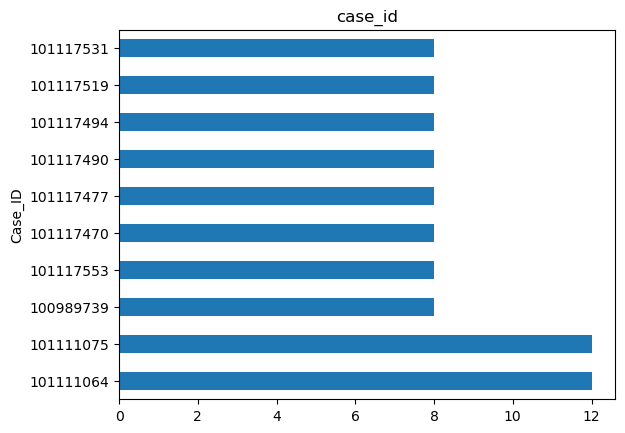

In [18]:
#Plot the top 10 of cases frequency
log.Case_ID.value_counts()[:10].plot(y='case_id', kind='barh', title='case_id')
plt.show()

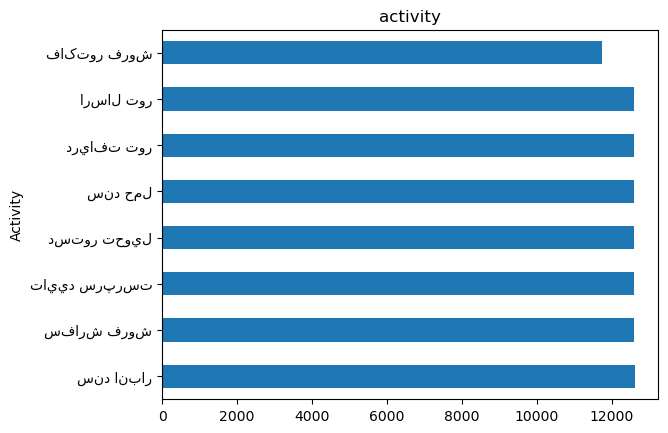

In [19]:
#Plot the activities frequency
log.Activity.value_counts().plot(y='activity', kind='barh', title='activity')
plt.show()

In [20]:
log.Start_Timestamp.nunique()

41107

In [21]:
# Multiple occurences: timestamp
pd.DataFrame(log.Start_Timestamp.value_counts()).head(10)

,count
Start_Timestamp,
2021-10-10 08:54:21,52
2021-10-09 15:45:56,52
2021-10-07 16:03:37,52
2021-09-29 15:19:45,45
2021-10-16 14:25:15,44
2021-10-16 11:23:57,44
2021-10-14 15:34:23,44
2021-10-04 14:27:28,44
2021-09-26 17:17:04,43


In [22]:
def activity_duration(
    event_log: pd.DataFrame, 
    case_var: str, 
    event_var: str, 
    timestamp_var: str, 
    duration: str ='h'
) -> pd.DataFrame:
    
    """
    Returns a dataframe with activity durations (i.e. 'arc' performance decorators).
    By default duration is set to hours (h).
    Use 's' for seconds, 'D' for days and 'W' for weeks.
    """
    
    event_log = event_log.rename(columns = {event_var:'event_from', timestamp_var:'time_from'})

    # Method 1
    data = {}

    # # Method 2
    # activity_duration_df = pd.DataFrame()
    
    
    groups = event_log.groupby(case_var)
    for name, group in groups:
        arc = group.sort_values('time_from')
        arc['event_to'] = arc['event_from'].shift(-1)
        arc['time_to'] = arc['time_from'].shift(-1)
        arc.dropna(inplace = True)
        duration_var = f'duration ({duration})'
        arc[duration_var] = (arc['time_to'] - arc['time_from']) / np.timedelta64(1, duration)
        
        # Method 1
        data[name] = arc[[case_var, 'event_from', 'event_to', 'time_from', 'time_to', duration_var]]

        # # Method 2
        # arc = arc[[case_var, 'event_from', 'event_to', 'time_from', 'time_to', duration_var]]
        # activity_duration_df = pd.concat([activity_duration_df, arc], axis=0)
    return pd.concat(data.values()).set_index(case_var)

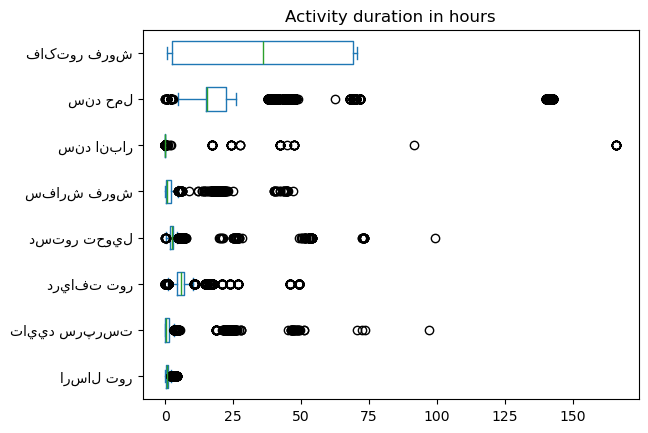

In [23]:
ad_df = activity_duration(log, 'Case_ID', 'Activity', 'Start_Timestamp')
ad_df = ad_df[['event_from', 'event_to', 'duration (h)']].reset_index()
ad_df = ad_df.pivot(columns='event_from', values='duration (h)')
ad_df.plot(kind='box', vert=False, title='Activity duration in hours')
plt.show()

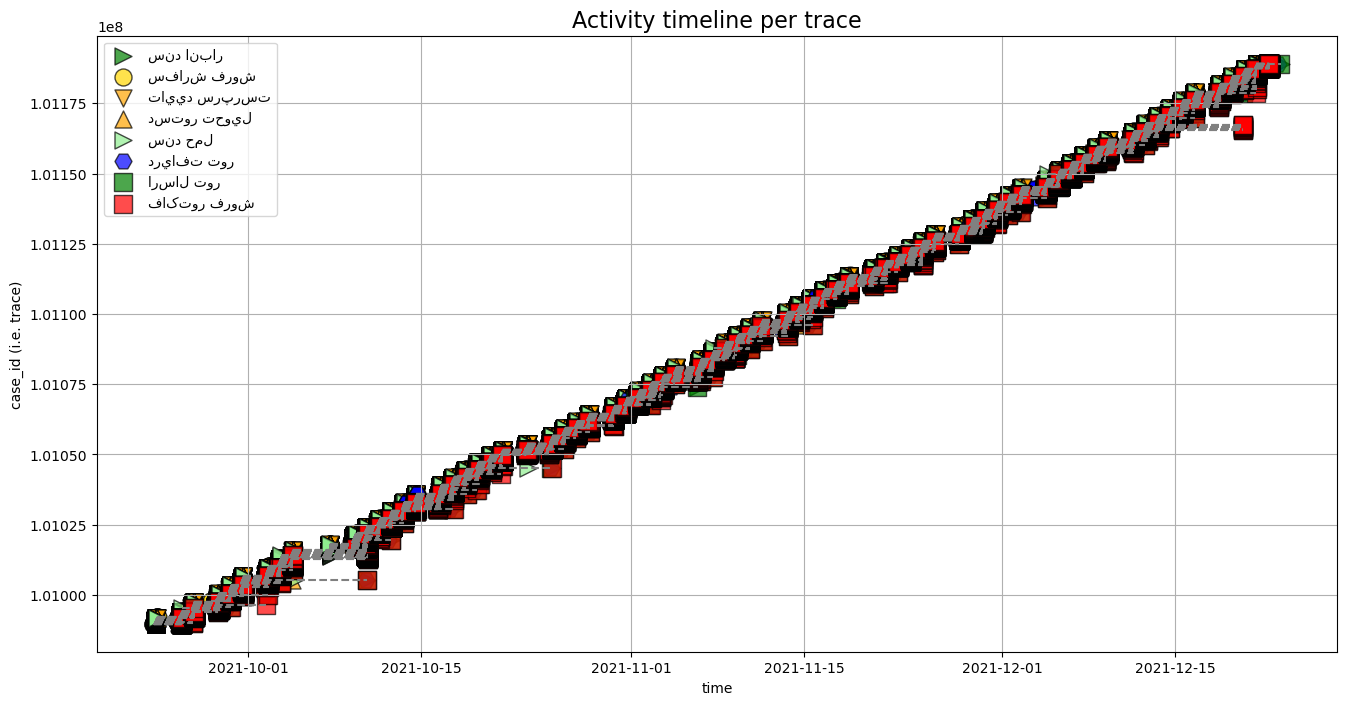

In [24]:
# Settings
activity = {
    'سند انبار': ('>', 'green'), 
    'سفارش فروش': ('o', 'gold'), 
    'تاييد سرپرست': ('v', 'orange'), 
    'دستور تحويل': ('^', 'orange'), 
    'سند حمل': ('>', 'lightgreen'), 
    'دريافت تور': ('H', 'blue'), 
    'ارسال تور': ('s', 'green'), 
    'فاکتور فروش': ('s', 'red'),
}


# Figure
fig, ax = plt.subplots(figsize=(16, 8))


# Timelines
log_agg_by_case = log.groupby('Case_ID').agg(time_start = ('Start_Timestamp', min),
                                                     time_end = ('Start_Timestamp', max)).reset_index()
log_agg_by_case
for timeline in log_agg_by_case.itertuples(index=False):
    plt.hlines(timeline.Case_ID, timeline.time_start, timeline.time_end, 
               colors = 'grey', linestyles = 'dashed')

# Activities
for act in activity.keys():
    ax.scatter(log.loc[log.Activity == act, 'Start_Timestamp'], 
               log.loc[log.Activity == act, 'Case_ID'],
               marker = activity[act][0],
               color = activity[act][1], 
               s = 150, 
               alpha = .7,
               label = act,
               edgecolors = 'black',
              )

ax.set_title('Activity timeline per trace', fontsize=16)
ax.set_xlabel('time')
ax.set_ylabel('case_id (i.e. trace)')
ax.legend()
ax.grid(True)

plt.show()

<br></br>
### <b>2.3.13. Frequency Table</b>

In [25]:
def dfg_frequency_matrix(
    event_log: pd.DataFrame, 
    case_var: str, 
    event_var: str, 
    timestamp_var: str
) -> pd.DataFrame:
    
    """
    Return a directly-follows graph frequency matrix based on the traces in the event log.
    Row events (i.e. the index) are events 'from' and column events are the events 'to'.
    """
    
    # event log
    log = event_log[[case_var, event_var, timestamp_var]]
    
    # initiate matrix
    events = log[event_var].unique()
    matrix = pd.DataFrame(columns=events, index=events).fillna(0)
    
    # groupby case_var
    groups = log.groupby(case_var)
    
    # loop through case groups
    for name, group in groups:
        event = group.sort_values(timestamp_var)\
                     .drop([case_var, timestamp_var], axis = 1)\
                     .rename(columns = {event_var:'event_from'})

        event['event_to'] = event['event_from'].shift(-1)
        event.dropna(inplace = True)
        
        # loop through traces
        for trace in event.itertuples(index = False):
            matrix.at[trace.event_from, trace.event_to] += 1

    return matrix.replace(0, np.nan)

In [26]:
def frequency_table(dfg_frequency_matrix: pd.DataFrame) -> pd.DataFrame:
    
    """
    Returns an directly-follows graph frequency table
    """
    
    arcs = list()
    
    for row in dfg_frequency_matrix.index:
        for col in dfg_frequency_matrix.columns:
            if not np.isnan(dfg_frequency_matrix.at[row, col]):
                arcs.append((row, col, dfg_frequency_matrix.at[row, col]))
    
    arc_freq = pd.DataFrame(arcs, columns = ['event_from', 'event_to', 'frequency'])\
    .set_index(['event_from', 'event_to'])
    
    return arc_freq

In [27]:
frequencey_matrix = dfg_frequency_matrix(log, 'Case_ID', 'Activity', 'Start_Timestamp')
af_df = frequency_table(frequencey_matrix).reset_index()
af_df

,event_from,event_to,frequency
0,سفارش فروش,تاييد سرپرست,12603.0
1,تاييد سرپرست,دستور تحويل,12603.0
2,دستور تحويل,سند حمل,12598.0
3,دستور تحويل,دريافت تور,5.0
4,سند حمل,سفارش فروش,5.0
5,سند حمل,دريافت تور,12598.0
6,دريافت تور,ارسال تور,12603.0
7,ارسال تور,سند انبار,12603.0
8,سند انبار,سند انبار,2.0
9,سند انبار,فاکتور فروش,11746.0


<br></br>
### <b>2.3.14. Extract Activities Duration From Events</b>

In [28]:
ad_df = activity_duration(log, 'Case_ID', 'Activity', 'Start_Timestamp').loc[:, ['event_from', 'event_to', 'duration (h)']]
ad_df = ad_df.groupby(by = ['event_from', 'event_to']).agg(
    mean_duration = ('duration (h)', 'mean')
).reset_index()
ad_df

,event_from,event_to,mean_duration
0,ارسال تور,سند انبار,0.776077
1,تاييد سرپرست,دستور تحويل,1.171383
2,دريافت تور,ارسال تور,5.796661
3,دستور تحويل,دريافت تور,2.010444
4,دستور تحويل,سند حمل,2.752147
5,سفارش فروش,تاييد سرپرست,1.525684
6,سند انبار,سند انبار,1.996250
7,سند انبار,فاکتور فروش,0.319522
8,سند حمل,دريافت تور,23.510841
9,سند حمل,سفارش فروش,17.974056


<br></br>
### <b>2.3.15. Frequency-Duration Table</b>

In [29]:
ad_df = activity_duration(log, 'Case_ID', 'Activity', 'Start_Timestamp').loc[:, ['event_from', 'event_to', 'duration (h)']]

ad_df = ad_df.groupby(by = ['event_from', 'event_to']).agg(
    mean_duration = ('duration (h)', 'mean'),
    total_duration = ('duration (h)', 'sum'),
    std_duration = ('duration (h)', 'std'),
    count = ('event_from', 'count')
).reset_index()

# ad_df.sort_values('total_duration', ascending=False)
ad_df

,event_from,event_to,mean_duration,total_duration,std_duration,count
0,ارسال تور,سند انبار,0.776077,9780.896389,0.630169,12603
1,تاييد سرپرست,دستور تحويل,1.171383,14762.936389,3.642978,12603
2,دريافت تور,ارسال تور,5.796661,73055.320278,4.722683,12603
3,دستور تحويل,دريافت تور,2.010444,10.052222,1.495084,5
4,دستور تحويل,سند حمل,2.752147,34671.554167,3.821181,12598
5,سفارش فروش,تاييد سرپرست,1.525684,19228.193889,3.052040,12603
6,سند انبار,سند انبار,1.996250,3.992500,0.071693,2
7,سند انبار,فاکتور فروش,0.319522,3753.103889,5.789051,11746
8,سند حمل,دريافت تور,23.510841,296189.579167,18.976553,12598
9,سند حمل,سفارش فروش,17.974056,89.870278,0.983692,5


<br></br>
### <b>2.3.16. Frequency Table Heatmap</b>

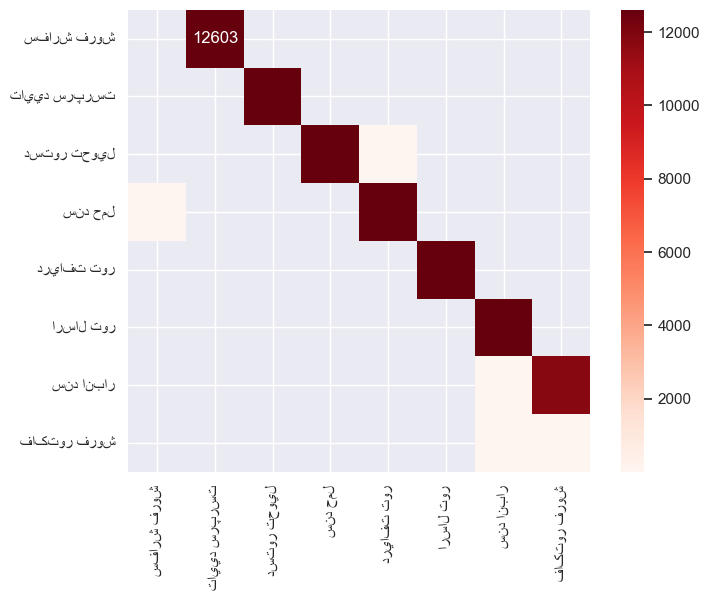

In [30]:
dfg_freq_matrix = dfg_frequency_matrix(log, 'Case_ID', 'Activity', 'Start_Timestamp')
sns.set(rc={'figure.figsize':(8, 6)})
sns.heatmap(dfg_freq_matrix, annot=True, fmt='.0f', cmap='Reds', square=True)
plt.show()

<br></br>
### <b>2.3.17. Activities Duration Heatmap</b>

In [31]:
def dfg_performance_matrix(
    event_log: pd.DataFrame, 
    case_var: str, 
    event_var: str, 
    timestamp_var: str, 
    duration: str ='h'
) -> pd.DataFrame:
    
    """
    Return a directly-follows graph duration matrix based on the traces in the event log.
    Row events (i.e. the index) are events 'from' and column events are the events 'to'.
    By default duration is set to hours (h). Use 's' for seconds, 'D' for days and 'W' for weeks.
    """
    
    # event log
    log = event_log[[case_var, event_var, timestamp_var]]
    
    # initiate matrix
    events = log[event_var].unique()
    matrix = pd.DataFrame(columns=events, index=events)
    
    # groupby case_var
    groups = log.groupby(case_var)
    
    # loop through case groups
    for group in groups:
        event = group[1].sort_values(timestamp_var)\
                        .rename(columns = {event_var:'event_from', timestamp_var:'time_begin'})

        event['event_to'] = event['event_from'].shift(-1)
        event['time_end'] = event['time_begin'].shift(-1)
        event['duration'] = (event['time_end'] - event['time_begin']) / np.timedelta64(1, duration)
        event.dropna(inplace = True)
        
        # loop through traces
        for row in event.itertuples(index = False):
            matrix.at[row.event_from, row.event_to] = np.nansum([matrix.at[row.event_from, row.event_to], row.duration])
    
    return matrix.astype(float)

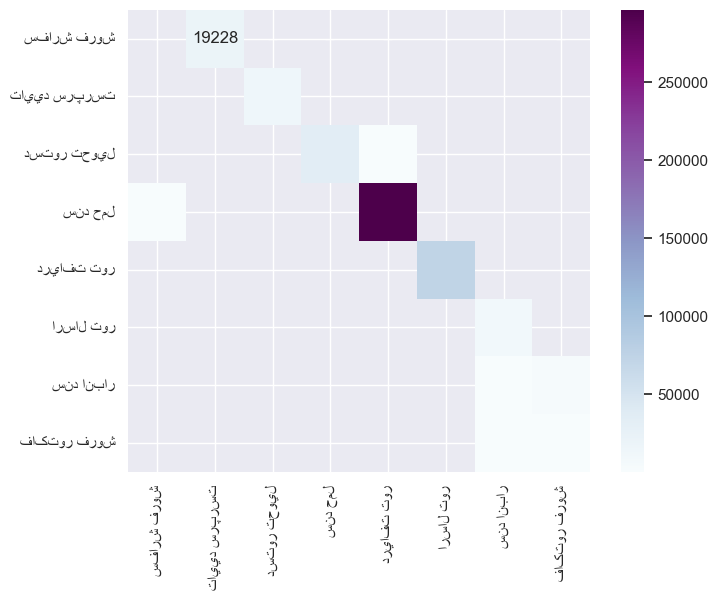

In [32]:
# Directly-Follows Graph total duration heapmap (in hours)
dfg_perf_matrix = dfg_performance_matrix(log, 'Case_ID', 'Activity', 'Start_Timestamp', duration='h')
sns.set(rc={'figure.figsize':(8, 6)})
sns.heatmap(dfg_perf_matrix, annot=True, fmt='.0f', cmap='BuPu', square=True)
plt.show()

## Generate Variants

In [33]:
log.sort_values(['Start_Timestamp'], inplace=True)

variants = log.groupby('Case_ID')['Activity'].apply(tuple).reset_index()

In [34]:
pd.DataFrame(variants.Activity.value_counts()).head(10)

,count
Activity,
"(سفارش فروش, تاييد سرپرست, دستور تحويل, سند حمل, دريافت تور, ارسال تور, سند انبار, فاکتور فروش)",11729
"(سفارش فروش, تاييد سرپرست, دستور تحويل, سند حمل, دريافت تور, ارسال تور, سند انبار)",859
"(سند حمل, سفارش فروش, تاييد سرپرست, دستور تحويل, دريافت تور, ارسال تور, سند انبار, فاکتور فروش)",5
"(سفارش فروش, تاييد سرپرست, دستور تحويل, سند حمل, دريافت تور, ارسال تور, فاکتور فروش, سند انبار)",5
"(تاييد سرپرست, سفارش فروش, دستور تحويل, سند حمل, دريافت تور, ارسال تور, سند انبار, فاکتور فروش)",2
"(سفارش فروش, تاييد سرپرست, دستور تحويل, سند حمل, دريافت تور, ارسال تور, سند انبار, فاکتور فروش, فاکتور فروش, سند انبار, سند انبار, فاکتور فروش)",2
"(سفارش فروش, دستور تحويل, تاييد سرپرست, سند حمل, دريافت تور, ارسال تور, سند انبار, فاکتور فروش)",1


### <b>Tamrin 1 <b>

In [35]:
#Tamrin 1:
ad_df = activity_duration(log, 'Cust_desc', 'Activity', 'Start_Timestamp').loc[:, ['event_from', 'event_to', 'duration (h)']]
ad_df = ad_df.groupby(by = ['Cust_desc']).agg(
    mean_duration = ('duration (h)', 'mean')
).sort_values('mean_duration').reset_index()
ad_df
#گروه خرده فروشی دارای کمترین میانگین زمان انجام فرآیند است

,Cust_desc,mean_duration
0,خرده فروشي,0.023559
1,مدير فروش سرد,0.407720
2,عمده فروشی,1.415149
3,نهاد/ارگان,11.013406
4,تعاونی,16.115221
5,هورکا,28.379800


In [36]:
dataset[dataset['Ret_status']=='مرجوع شده'].groupby(by = ['Cust_desc']).agg(
    count = ('Ret_status', 'count')
).sort_values('count').reset_index()
#گروه های "تعاونی" و "نهاد/ارگان" دارای کمترین نرخ مرجوعی است

,Cust_desc,count
0,تعاونی,7
1,نهاد/ارگان,7
2,عمده فروشی,14
3,مدير فروش سرد,147
4,خرده فروشي,5838


### <b>Tamrin 2 <b> 

In [37]:
log.Start_Timestamp[1].strftime('%A')


'Thursday'

In [38]:
log.Start_Timestamp[1]

Timestamp('2021-09-23 11:38:51')

<Axes: xlabel='Month'>

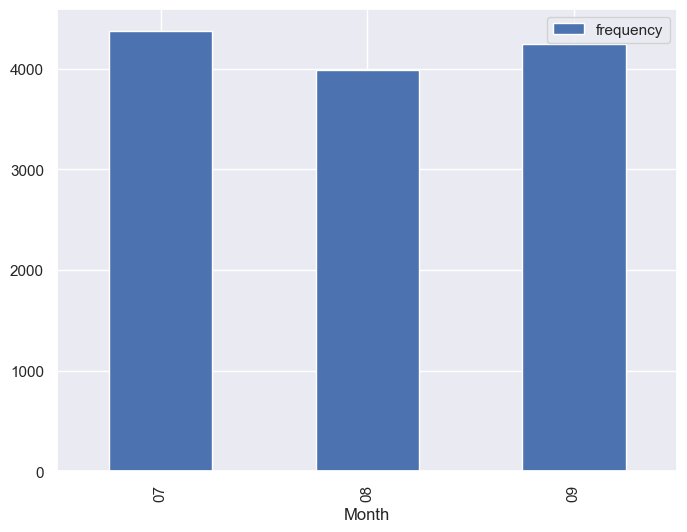

In [39]:
freq_per_month=dataset[dataset.Activity == 'سفارش فروش'].groupby(by = ['Month']).agg(
    frequency = ('Activity', 'count')
).reset_index()
freq_per_month.plot(kind='bar', x='Month')


In [40]:
log ['Day_of_week'] = log.Start_Timestamp.apply(lambda x: x.strftime('%A'))

In [41]:
categories = ['Saturday', 'Sunday', 'Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday']
log['Day_of_week'] = pd.Categorical(log['Day_of_week'], categories=categories, ordered=True)
sorted_df = log.sort_values(by='Day_of_week')

<Axes: xlabel='Day_of_week'>

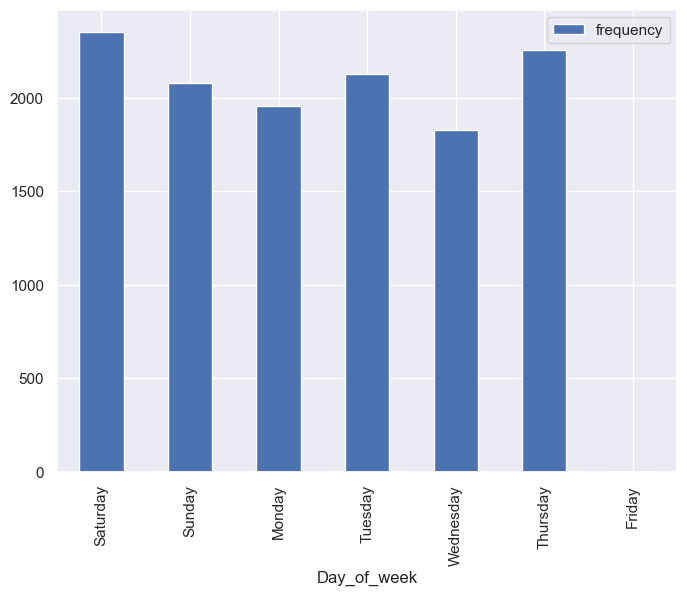

In [42]:
freq_per_day=log[log.Activity == 'سفارش فروش'].groupby(by = ['Day_of_week']).agg(
    frequency = ('Activity', 'count')
).reset_index()
freq_per_day.plot(kind='bar', x='Day_of_week')

### <b>Tamrin 3:<b>

In [43]:
dataset.sort_values(['Timestamp'], inplace=True)

variants = dataset.groupby('Case_ID')['Doc_type'].apply(tuple).reset_index()

In [44]:
pd.DataFrame(variants.Doc_type.value_counts())

,count
Doc_type,
"(ZO20, ZO20, ZLF3, ZP01, ZP01, ZP01, WL, ZF01)",11732
"(ZO20, ZO20, ZLF3, ZP01, ZP01, ZP01, WL)",859
"(ZP01, ZO20, ZO20, ZLF3, ZP01, ZP01, WL, ZF01)",5
"(ZO20, ZO20, ZLF3, ZP01, ZP01, ZP01, ZF01, WL)",5
"(ZO20, ZO20, ZLF3, ZP01, ZP01, ZP01, WL, ZF01, ZSF1, WL, WL, ZF01)",2


In [45]:
log2 = log.copy()
log2['concept:name'] = log['Doc_type']

In [46]:
log2.Case_ID = log2.Case_ID.apply(str)

pm4py.format_dataframe(
    log2,
    case_id = 'Case_ID',
    activity_key = 'Doc_type',
    timestamp_key = 'Start_Timestamp', 
    timest_format = '%Y-%m-%d %H:%M:%S%z'
)

log2.head()

,Case_ID,Activity,Start_Timestamp,Cust_desc,Doc_type,End_Timestamp,Shifted_CaseID,Next_Event,TimeBetweetEvents,Day_of_week,case:concept:name,concept:name,time:timestamp
0,100989739,سفارش فروش,2021-09-23 08:11:44,خرده فروشي,ZO20,2021-09-23 11:38:51,100989739.0,تاييد سرپرست,12427.0,Thursday,100989739,ZO20,2021-09-23 08:11:44
8,100989752,سفارش فروش,2021-09-23 08:20:41,خرده فروشي,ZO20,2021-09-23 11:38:58,100989752.0,تاييد سرپرست,11897.0,Thursday,100989752,ZO20,2021-09-23 08:20:41
16,100989754,سفارش فروش,2021-09-23 08:22:04,خرده فروشي,ZO20,2021-09-23 11:39:04,100989754.0,تاييد سرپرست,11820.0,Thursday,100989754,ZO20,2021-09-23 08:22:04
24,100989758,سفارش فروش,2021-09-23 08:27:13,خرده فروشي,ZO20,2021-09-23 11:39:09,100989758.0,تاييد سرپرست,11516.0,Thursday,100989758,ZO20,2021-09-23 08:27:13
32,100989776,سفارش فروش,2021-09-23 08:37:20,خرده فروشي,ZO20,2021-09-23 11:39:14,100989776.0,تاييد سرپرست,10914.0,Thursday,100989776,ZO20,2021-09-23 08:37:20


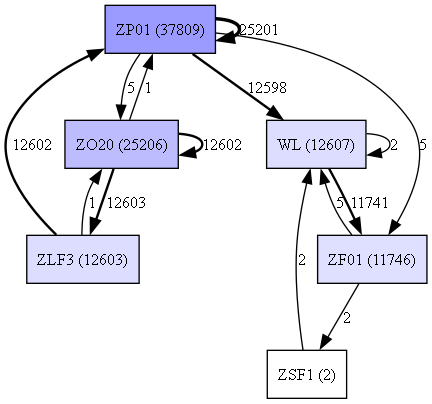

In [47]:
# Miner
dfg = dfg_discovery.apply(log2, variant=dfg_discovery.Variants.FREQUENCY)

# GraphViz
gviz = dfg_visualization.apply(dfg, log=log2, variant=dfg_visualization.Variants.FREQUENCY)

# View
dfg_visualization.view(gviz)

In [48]:
#نوع سند را به عنوان فعالیت در نظر گرفتیم، بر اساس آن واریانت های مختلف را محاسبه کردیم و سپس نمودار دی اف جی آن را رسم کردیم، مشخص است که سند زد پی 01 بیشترین تکرار را داشته است و 25201 بار مجددا تکرار شده است
# باید در نظر گرفت که نوع سند در برخی از فعالیت ها مشترک است و این تحلیل صرفا بر اساس نوع سند است و دوباره کاری در کلیه فرآیند فقط برای 4 بار (دو مورد هر کدام دو بار) اتفاق افتاده است

### <b>Tamrin 4:<b>

In [49]:
# فرآیند استخراج شده مبنی بر انواع الگوریتم های متفاوت و معیارهای کارایی و میزان توزیع در ادامه انجام شده است.

<br><br>
## <b>1.2. Setting</b>

In [50]:
pd.set_option('display.max_rows', 50)

In [51]:
sns.set_theme()

<br><br>
## <b>1.3. Import Event Log</b>

In [52]:
event_log = log.copy()
pm4py.format_dataframe(
    log,
    case_id = 'Case_ID',
    activity_key = 'Activity',
    timestamp_key = 'Start_Timestamp', 
    timest_format = '%Y-%m-%d %H:%M:%S%z'
#     timestamp_key = 'Start_Timestamp', 
#     timest_format = '%Y-%m-%d'
)

log.head()

,Case_ID,Activity,Start_Timestamp,Cust_desc,Doc_type,End_Timestamp,Shifted_CaseID,Next_Event,TimeBetweetEvents,Day_of_week,case:concept:name,concept:name,time:timestamp
0,100989739,سفارش فروش,2021-09-23 08:11:44,خرده فروشي,ZO20,2021-09-23 11:38:51,100989739.0,تاييد سرپرست,12427.0,Thursday,100989739,سفارش فروش,2021-09-23 08:11:44
8,100989752,سفارش فروش,2021-09-23 08:20:41,خرده فروشي,ZO20,2021-09-23 11:38:58,100989752.0,تاييد سرپرست,11897.0,Thursday,100989752,سفارش فروش,2021-09-23 08:20:41
16,100989754,سفارش فروش,2021-09-23 08:22:04,خرده فروشي,ZO20,2021-09-23 11:39:04,100989754.0,تاييد سرپرست,11820.0,Thursday,100989754,سفارش فروش,2021-09-23 08:22:04
24,100989758,سفارش فروش,2021-09-23 08:27:13,خرده فروشي,ZO20,2021-09-23 11:39:09,100989758.0,تاييد سرپرست,11516.0,Thursday,100989758,سفارش فروش,2021-09-23 08:27:13
32,100989776,سفارش فروش,2021-09-23 08:37:20,خرده فروشي,ZO20,2021-09-23 11:39:14,100989776.0,تاييد سرپرست,10914.0,Thursday,100989776,سفارش فروش,2021-09-23 08:37:20


<br></br>
# <b>2. Process Dicovery</b>

<br></br>
## <b>2.1 Alpha Miner</b>

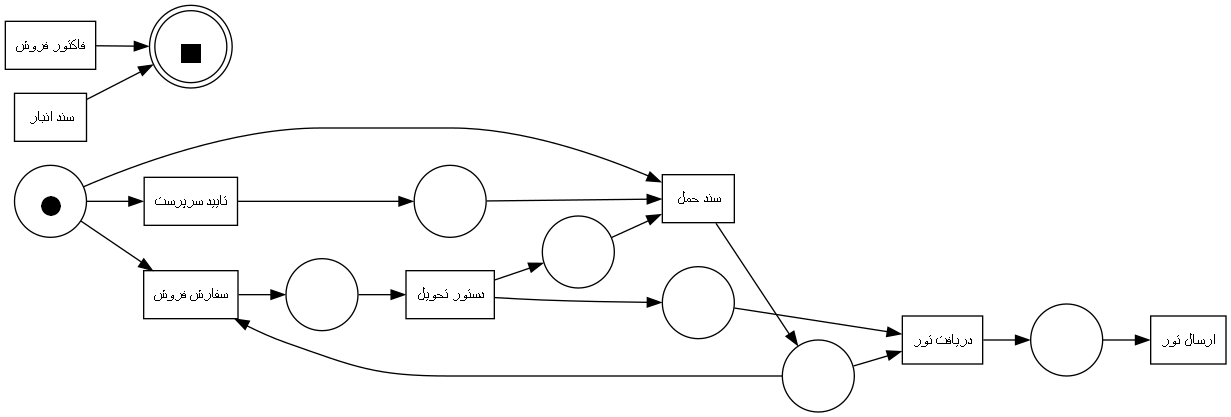

In [55]:
# Miner
petri_net, initial_marking, final_marking = alpha_miner.apply(log, variant=variants.classic)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking)

# Save
pn_visualizer.save(gviz, IMAGE_DIR / 'ProcessDiscovery/alpha_miner_classic_petri_default.png')

# View
pn_visualizer.view(gviz)

<br></br>
### <b>Performance</b>

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

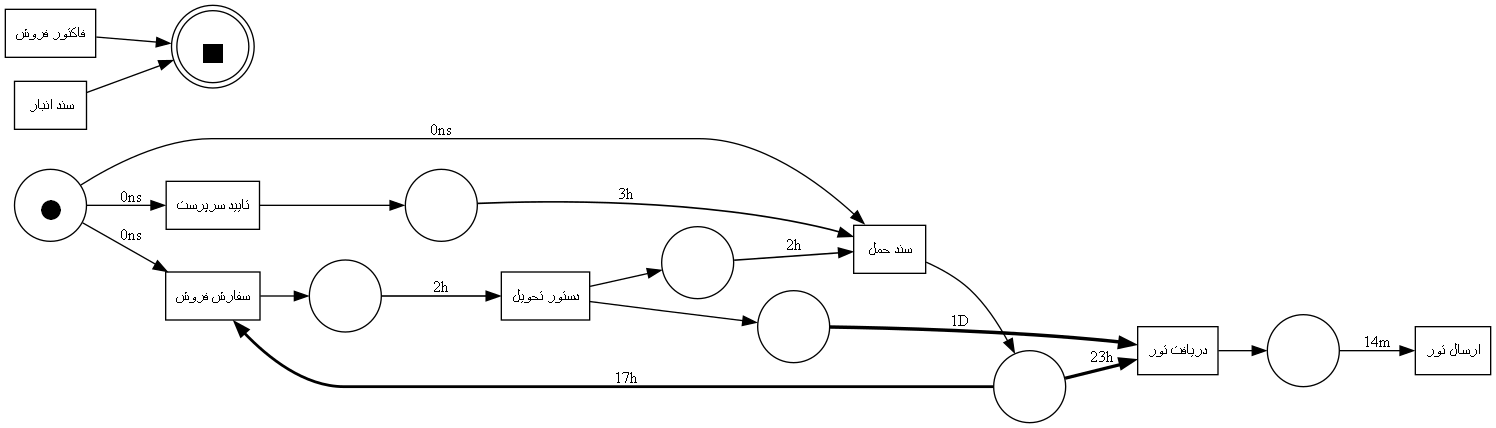

In [56]:
# Miner
petri_net, initial_marking, final_marking = alpha_miner.apply(log, variant=variants.classic)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking, 
                           variant=pn_visualizer.Variants.PERFORMANCE,
                           log=log)

# Save
pn_visualizer.save(gviz, IMAGE_DIR / 'ProcessDiscovery/alpha_miner_classic_petri_performance.png')

# View
pn_visualizer.view(gviz)

<br></br>
### <b>Frequency</b>

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

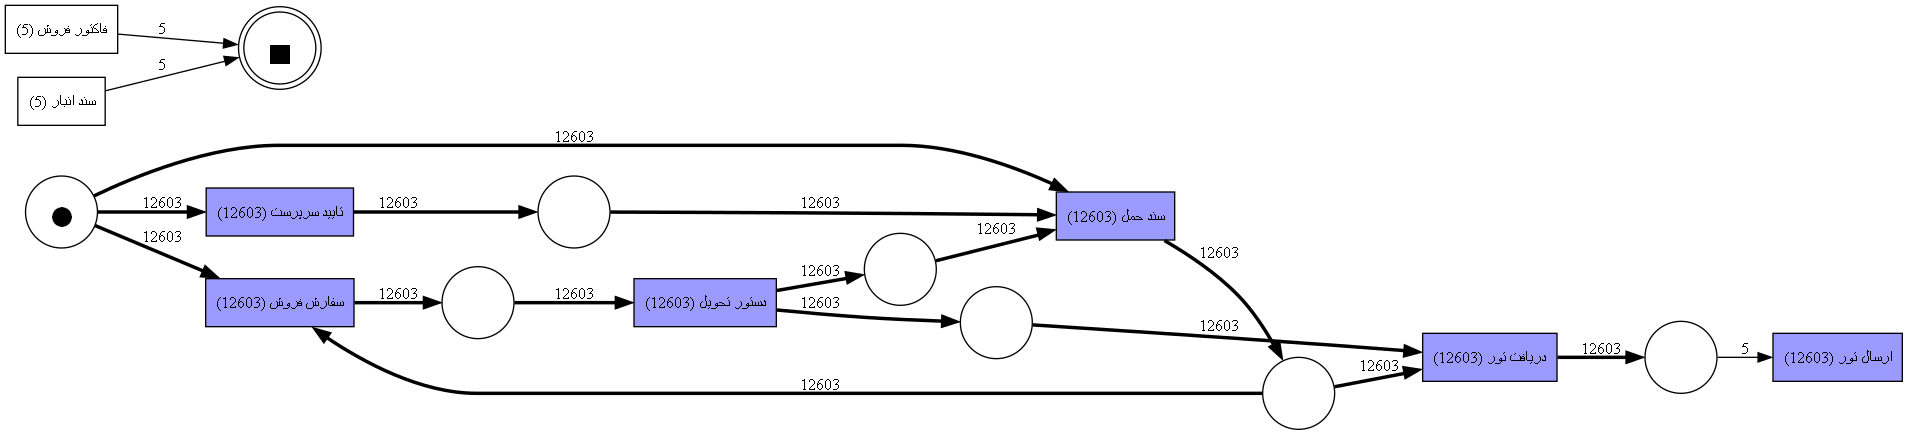

In [57]:
# Miner
petri_net, initial_marking, final_marking = alpha_miner.apply(log, variant=variants.classic)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking, 
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=log)

# Save
pn_visualizer.save(gviz, IMAGE_DIR / 'ProcessDiscovery/alpha_miner_classic_petri_frequency.png')

# View
pn_visualizer.view(gviz)

<br></br>
## <b>2.2 Alpha+ Miner</b>

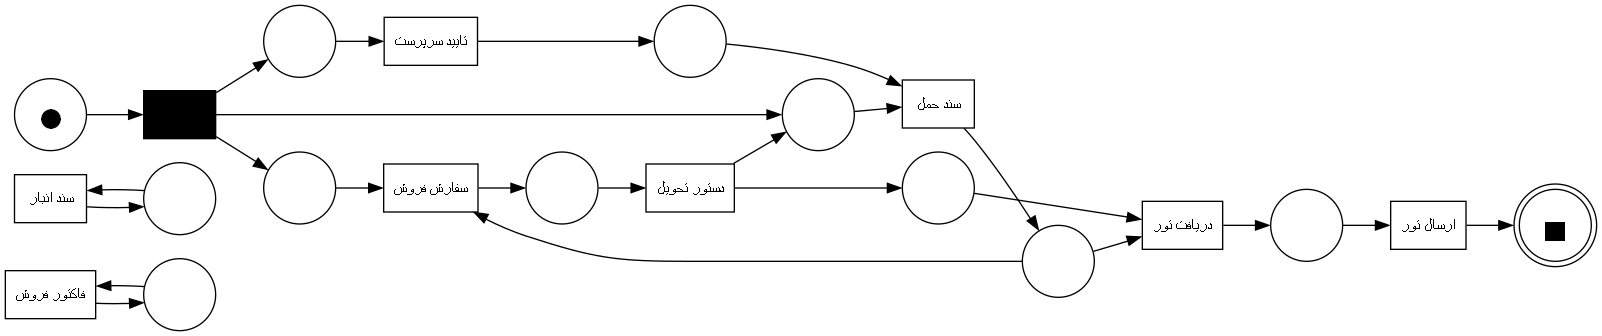

In [58]:
# Miner
petri_net, initial_marking, final_marking = alpha_miner.apply(log, variant=variants.plus)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking)

# Save
pn_visualizer.save(gviz, IMAGE_DIR / 'ProcessDiscovery/alpha_miner_plus_petri_default.png')

# View
pn_visualizer.view(gviz)

<br></br>
### <b>Performance</b>

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

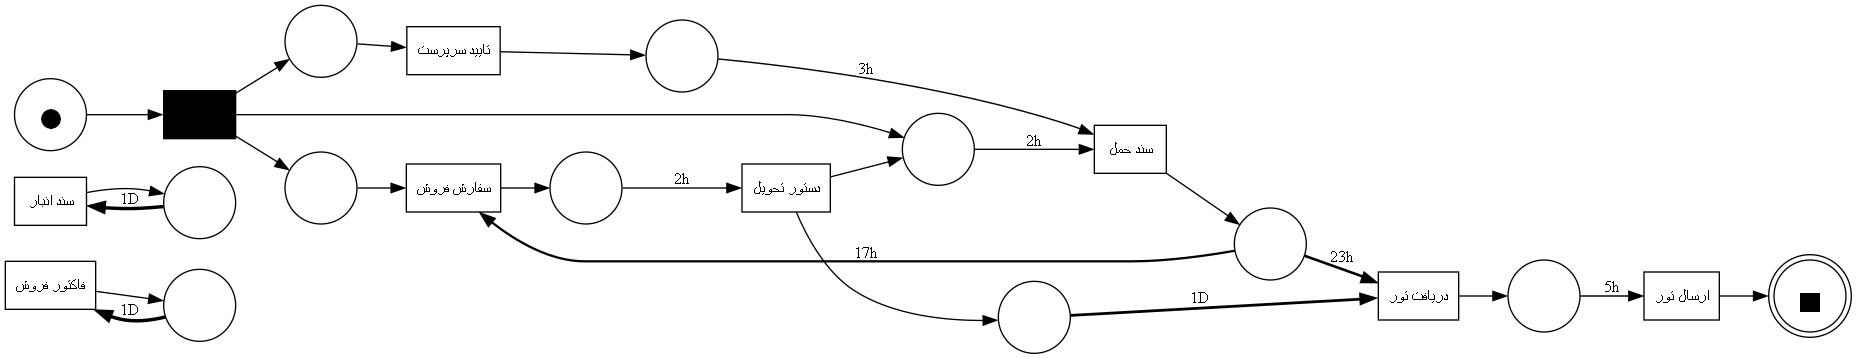

In [59]:
# Miner
petri_net, initial_marking, final_marking = alpha_miner.apply(log, variant=variants.plus)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking, 
                           variant=pn_visualizer.Variants.PERFORMANCE,
                           log=log)

# Save
pn_visualizer.save(gviz, IMAGE_DIR / 'ProcessDiscovery/alpha_miner_plus_petri_performance.png')

# View
pn_visualizer.view(gviz)

<br></br>
### <b>Frequency</b>

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

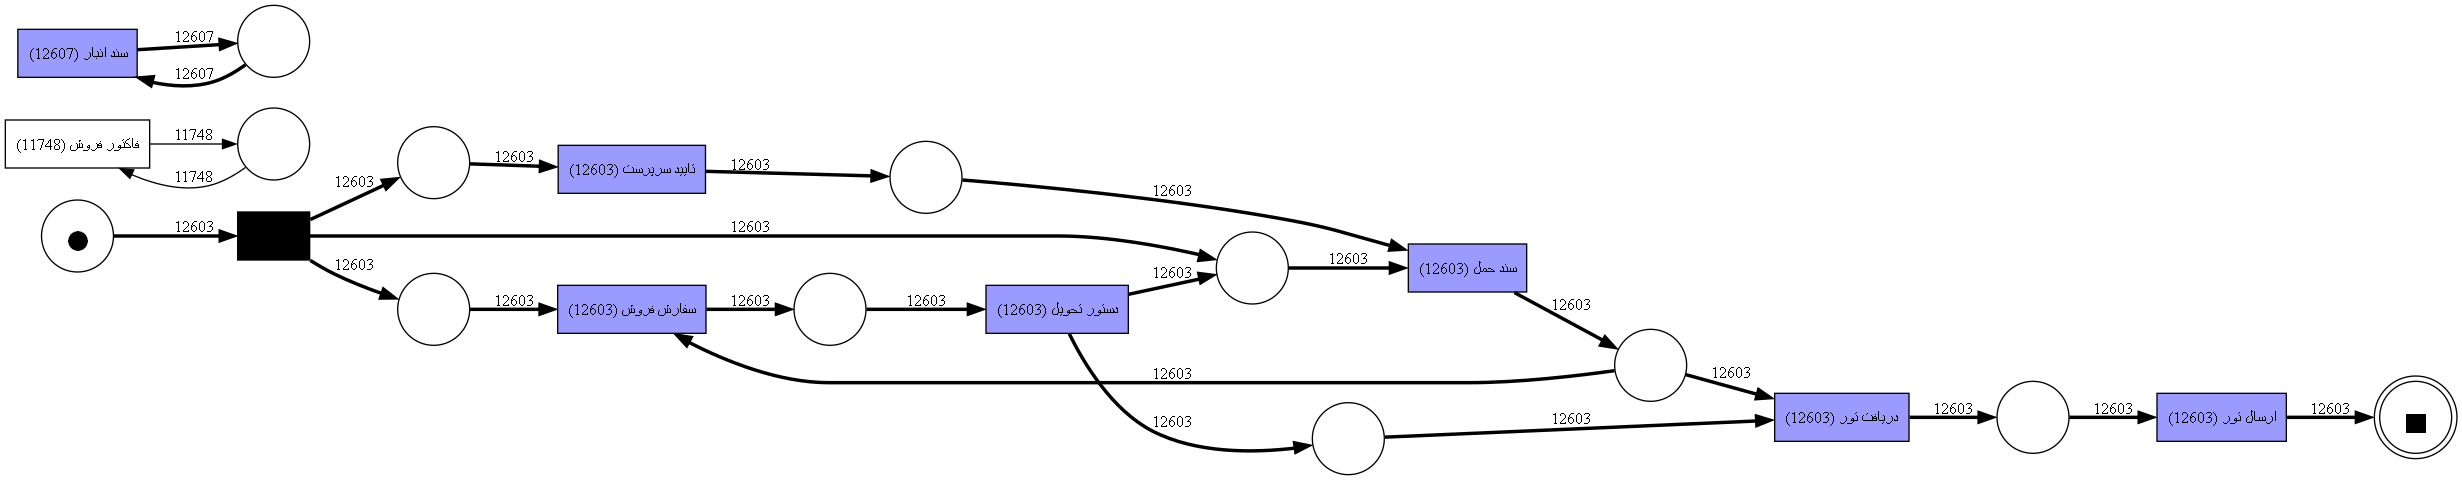

In [60]:
# Miner
petri_net, initial_marking, final_marking = alpha_miner.apply(log, variant=variants.plus)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking, 
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=log)

# Save
pn_visualizer.save(gviz, IMAGE_DIR / 'ProcessDiscovery/alpha_miner_plus_petri_frequency.png')

# View
pn_visualizer.view(gviz)

<br></br>
## <b>2.3 Heuristic Miner</b>

<br></br>
### <b>2.3.1. Implicit Default Parameters _ (Performance)</b>

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

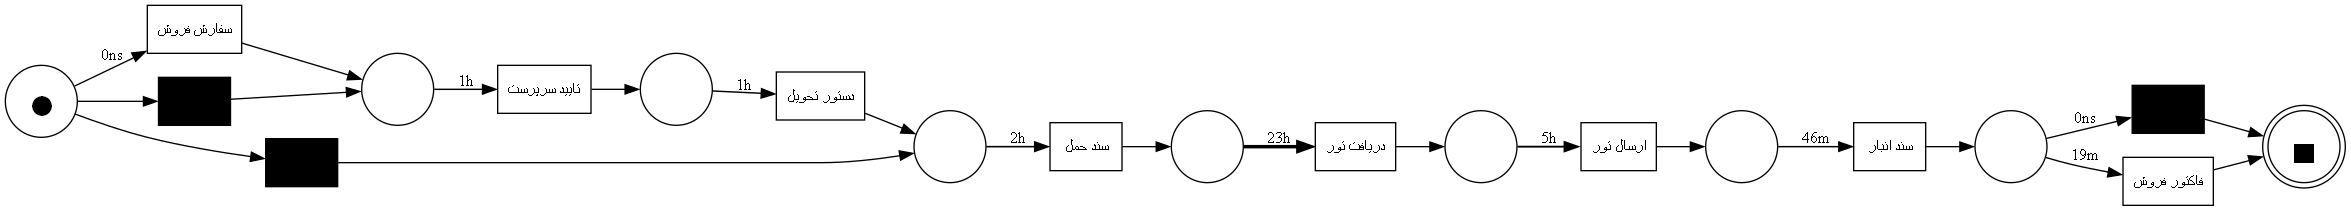

In [61]:
# Miner
petri_net, initial_marking, final_marking = heuristics_miner.apply(log)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking,
                           variant=pn_visualizer.Variants.PERFORMANCE, 
                           log=log)

# Save
pn_visualizer.save(gviz, IMAGE_DIR / 'ProcessDiscovery/heuristic_miner_1.png')

# View
pn_visualizer.view(gviz)

<br></br>
### <b>2.3.2. Implicit Default Parameters _ (Frequency)</b>

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

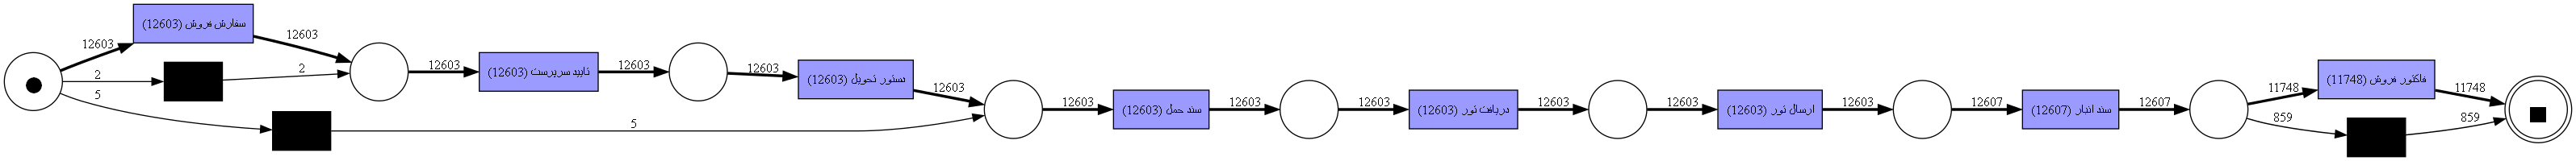

In [62]:
# Miner
petri_net, initial_marking, final_marking = heuristics_miner.apply(log)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking,
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

# Save
pn_visualizer.save(gviz, IMAGE_DIR / 'ProcessDiscovery/heuristic_miner_2.png')

# View
pn_visualizer.view(gviz)

<br></br>
### <b>2.3.3. Explicit Default Parameters _ (Performance)</b>

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

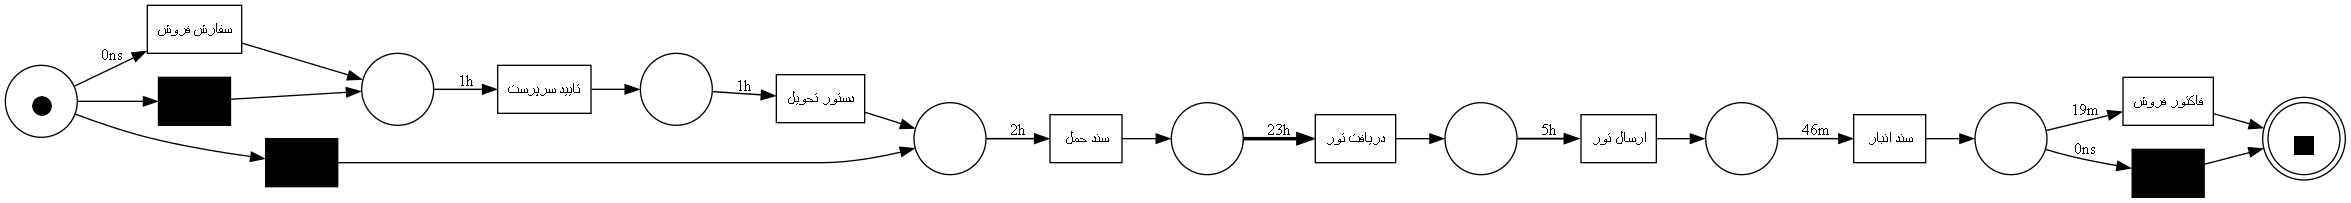

In [63]:
# Parameters
parameters = heuristics_miner.Variants.CLASSIC.value.Parameters

# Miner
petri_net, initial_marking, final_marking = heuristics_miner.apply(
    log,
    parameters={
        parameters.DEPENDENCY_THRESH: 0.5,
        parameters.AND_MEASURE_THRESH: 0.65,
        parameters.LOOP_LENGTH_TWO_THRESH: 0.5
    }
)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking,
                           variant=pn_visualizer.Variants.PERFORMANCE, 
                           log=log)

# Save
pn_visualizer.save(gviz, IMAGE_DIR / 'ProcessDiscovery/heuristic_miner_3.png')

# View
pn_visualizer.view(gviz)

<br></br>
### <b>2.3.4. Explicit Default Parameters _ (Frequency)</b>

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

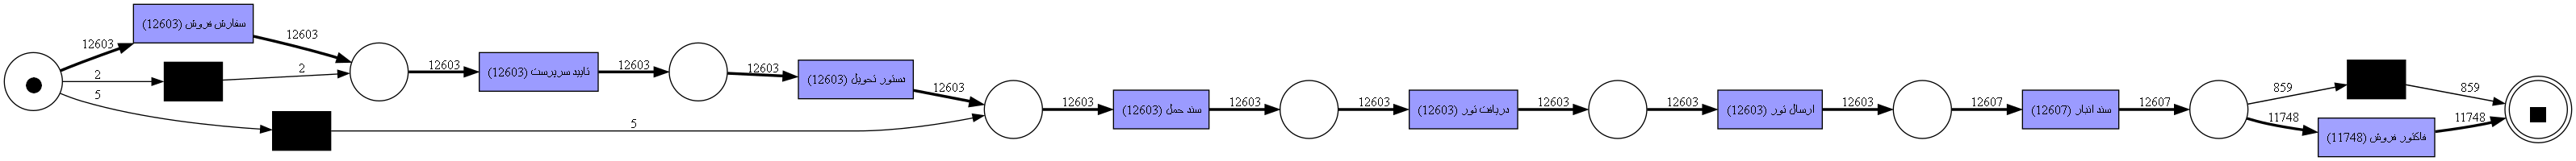

In [64]:
# Parameters
parameters = heuristics_miner.Variants.CLASSIC.value.Parameters

# Miner
petri_net, initial_marking, final_marking = heuristics_miner.apply(
    log,
    parameters={
        parameters.DEPENDENCY_THRESH: 0.5, 
        parameters.AND_MEASURE_THRESH: 0.65,
        parameters.LOOP_LENGTH_TWO_THRESH: 0.5
    }
)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking,
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

# Save
pn_visualizer.save(gviz, IMAGE_DIR / 'ProcessDiscovery/heuristic_miner_3.png')

# View
pn_visualizer.view(gviz)

<br></br>
## <b>2.4. Inductive Miner</b>

In [65]:
#log = xes_importer.apply(str(DATA_DIR / 'Example/Running_Example/running-example.xes'))

#log = pd.read_csv('./src/Datasets/Orders.xlsx', sep=',')

# in Inductive Mining algorithm, it needs the Case_ID should be string
event_log.Case_ID = event_log.Case_ID.apply(str)

pm4py.format_dataframe(
    event_log,
    case_id = 'Case_ID',
    activity_key = 'Activity',
    timestamp_key = 'Start_Timestamp', 
    timest_format = '%Y-%m-%d %H:%M:%S%z'
#     timestamp_key = 'Start_Timestamp', 
#     timest_format = '%Y-%m-%d'
)

event_log.head()

,Case_ID,Activity,Start_Timestamp,Cust_desc,Doc_type,End_Timestamp,Shifted_CaseID,Next_Event,TimeBetweetEvents,Day_of_week,case:concept:name,concept:name,time:timestamp
0,100989739,سفارش فروش,2021-09-23 08:11:44,خرده فروشي,ZO20,2021-09-23 11:38:51,100989739.0,تاييد سرپرست,12427.0,Thursday,100989739,سفارش فروش,2021-09-23 08:11:44
8,100989752,سفارش فروش,2021-09-23 08:20:41,خرده فروشي,ZO20,2021-09-23 11:38:58,100989752.0,تاييد سرپرست,11897.0,Thursday,100989752,سفارش فروش,2021-09-23 08:20:41
16,100989754,سفارش فروش,2021-09-23 08:22:04,خرده فروشي,ZO20,2021-09-23 11:39:04,100989754.0,تاييد سرپرست,11820.0,Thursday,100989754,سفارش فروش,2021-09-23 08:22:04
24,100989758,سفارش فروش,2021-09-23 08:27:13,خرده فروشي,ZO20,2021-09-23 11:39:09,100989758.0,تاييد سرپرست,11516.0,Thursday,100989758,سفارش فروش,2021-09-23 08:27:13
32,100989776,سفارش فروش,2021-09-23 08:37:20,خرده فروشي,ZO20,2021-09-23 11:39:14,100989776.0,تاييد سرپرست,10914.0,Thursday,100989776,سفارش فروش,2021-09-23 08:37:20


### <b>2.4.1. Performance</b>

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

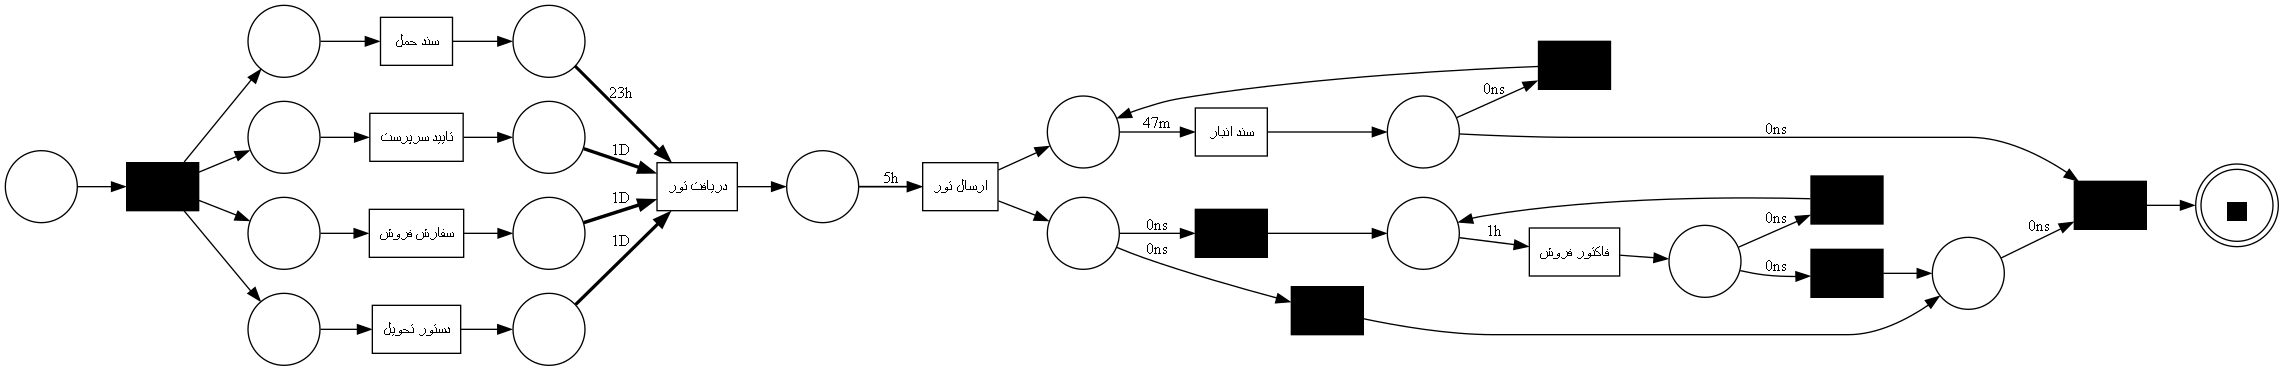

In [66]:
# Miner
petri_net, marking, final_marking = pm4py.discover_petri_net_inductive(event_log)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking,
                           variant = pn_visualizer.Variants.PERFORMANCE, 
                           log = event_log)

# Save
pn_visualizer.save(gviz, IMAGE_DIR / 'ProcessDiscovery/IM_performance_petri.png')

# View
pn_visualizer.view(gviz)

<br></br>
### <b>2.4.2. Frequency</b>

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

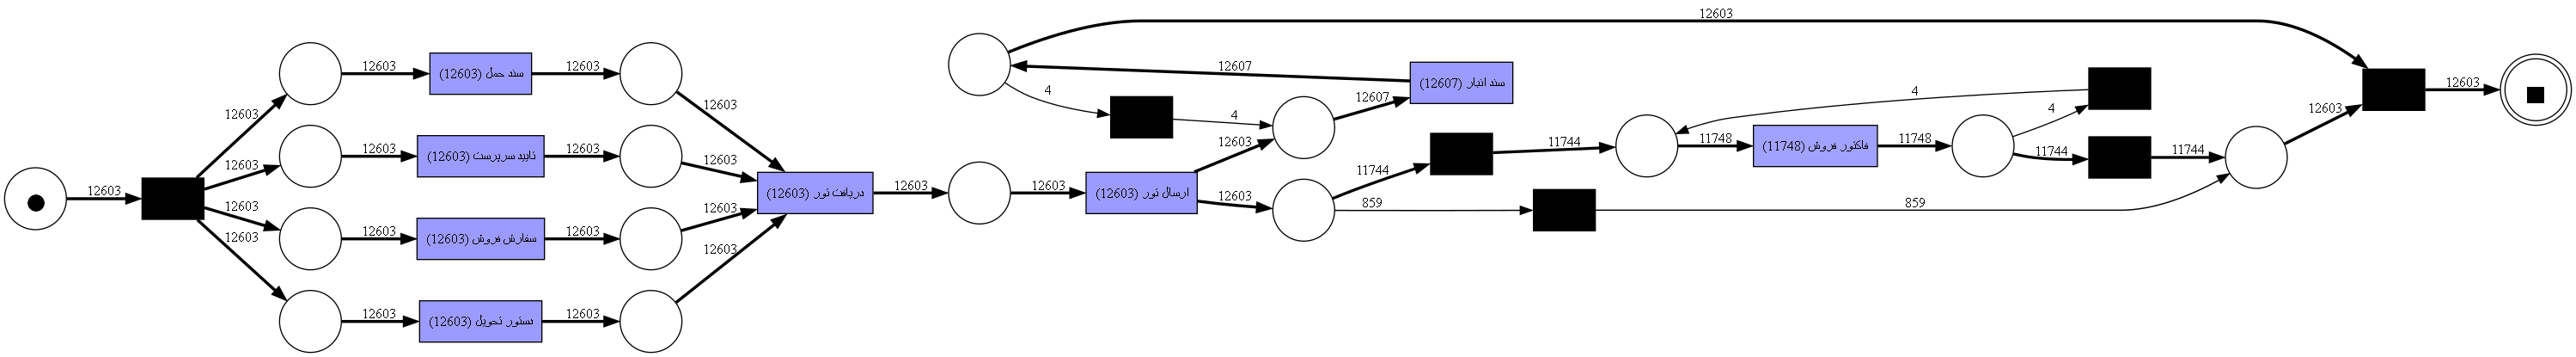

In [67]:
# Miner
petri_net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(event_log)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking,
                           variant = pn_visualizer.Variants.FREQUENCY, 
                           log = event_log)

# Save
pn_visualizer.save(gviz, IMAGE_DIR / 'ProcessDiscovery/IM_frequency_petri.png')

# View
pn_visualizer.view(gviz)

<br></br>
# <b>3. Other Process Map Types<b>

## <b>3.1. Process Tree<b>

### <b>3.1.1. Convert Petri Net to Process Tree<b>

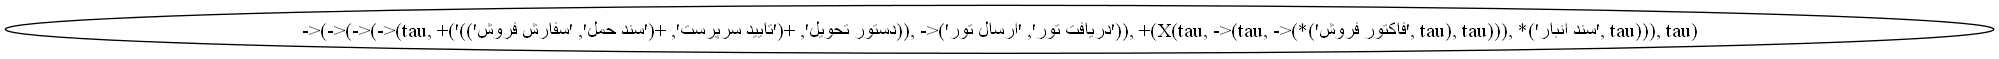

In [68]:
# Inductive Petri Net to process_tree

petri_net, marking, final_marking = pm4py.discover_petri_net_inductive(event_log)
process_tree = to_process_tree.apply(petri_net, marking, final_marking)
pm4py.view_process_tree(process_tree)

<br></br>
### <b>3.1.2. Convert Process Tree to Petri Net<b>

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

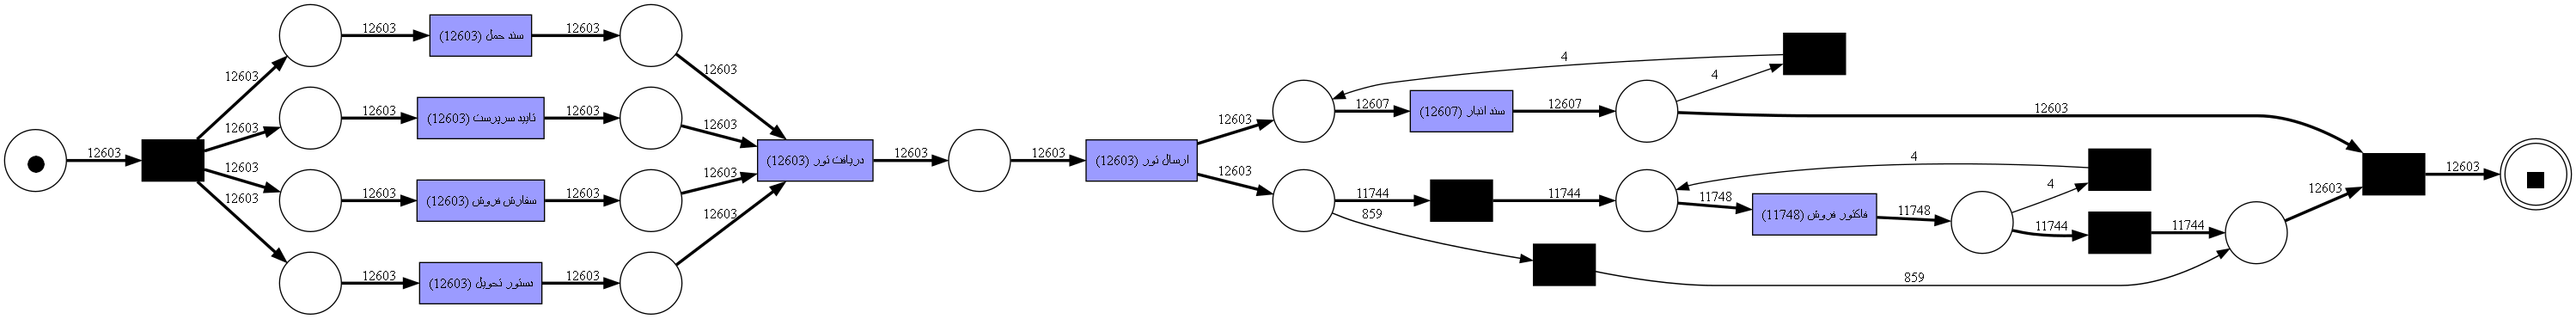

In [69]:
# Miner
tree = pm4py.discover_process_tree_inductive(event_log)

# Convert the process tree to a petri net
net, initial_marking, final_marking = pt_converter.apply(tree)


# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           parameters={pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: 'png'}, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=event_log)

# View
pn_visualizer.view(gviz)

<br></br>
## <b>3.2. BPMN<b>

### <b>3.2.1. Convert Petri Net to BPMN<b>

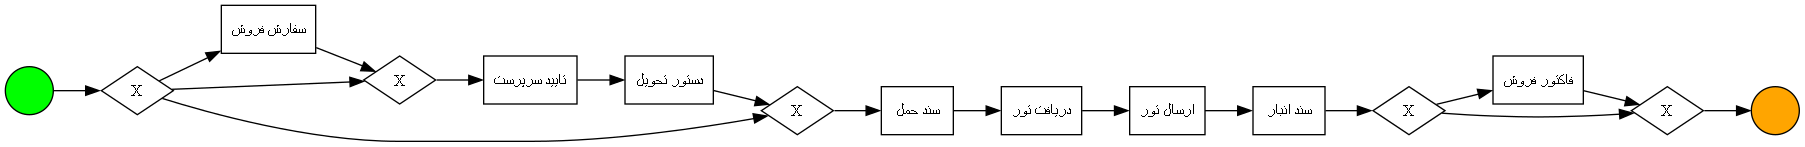

In [70]:
# Heuristics Petri Net to BPMN

petri_net, marking, final_marking = heuristics_miner.apply(log)

bpmn = to_bpmn.apply(petri_net, marking, final_marking)
pm4py.view_bpmn(bpmn)

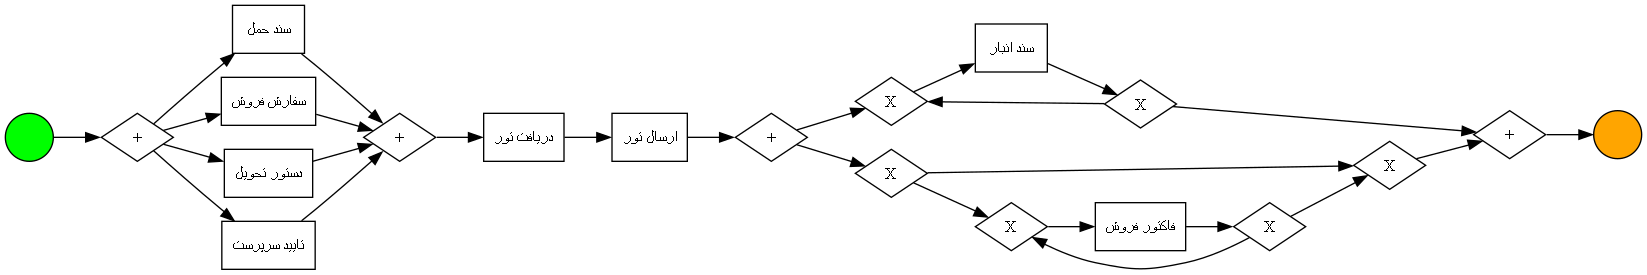

In [71]:
# Inductive Petri Net to BPMN

petri_net, marking, final_marking = pm4py.discover_petri_net_inductive(event_log)

bpmn = to_bpmn.apply(petri_net, marking, final_marking)
pm4py.view_bpmn(bpmn)

<br></br>
## <b>3.3 Directly-Follows Graph</b>

### <b>3.3.1. Direct extraction of the process map</b>

#### <b>3.3.1.1. Performance<b>

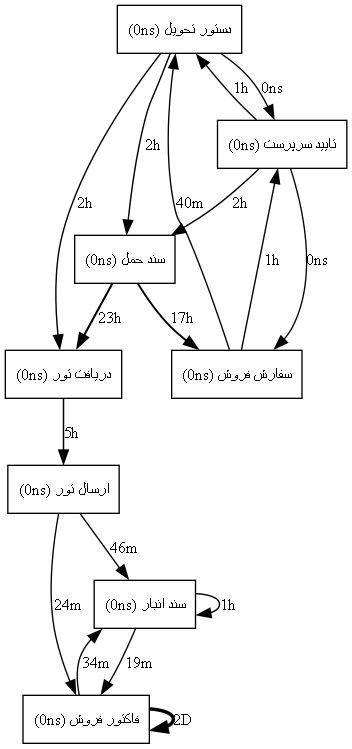

In [83]:
# Miner
dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.PERFORMANCE)

# GraphViz
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.PERFORMANCE)

# Save
dfg_visualization.save(gviz, IMAGE_DIR / 'ProcessDiscovery/dfg_performance.png')

# View
dfg_visualization.view(gviz)

<br></br>
#### <b>3.3.1.2. Frequency<b>

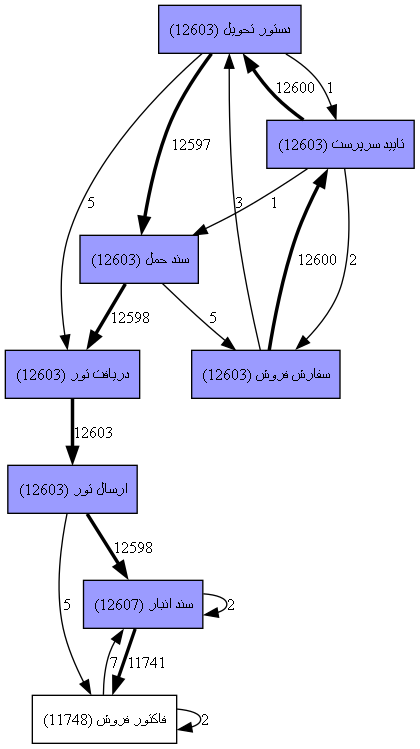

In [84]:
# Miner
dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.FREQUENCY)

# GraphViz
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)

# Save
dfg_visualization.save(gviz, IMAGE_DIR / 'ProcessDiscovery/dfg_frequency.png')

# View
dfg_visualization.view(gviz)

In [85]:
dfg

{('ارسال تور', 'سند انبار'): 12598,
 ('ارسال تور', 'فاکتور فروش'): 5,
 ('تاييد سرپرست', 'دستور تحويل'): 12600,
 ('تاييد سرپرست', 'سفارش فروش'): 2,
 ('تاييد سرپرست', 'سند حمل'): 1,
 ('دريافت تور', 'ارسال تور'): 12603,
 ('دستور تحويل', 'تاييد سرپرست'): 1,
 ('دستور تحويل', 'دريافت تور'): 5,
 ('دستور تحويل', 'سند حمل'): 12597,
 ('سفارش فروش', 'تاييد سرپرست'): 12600,
 ('سفارش فروش', 'دستور تحويل'): 3,
 ('سند انبار', 'سند انبار'): 2,
 ('سند انبار', 'فاکتور فروش'): 11741,
 ('سند حمل', 'دريافت تور'): 12598,
 ('سند حمل', 'سفارش فروش'): 5,
 ('فاکتور فروش', 'سند انبار'): 7,
 ('فاکتور فروش', 'فاکتور فروش'): 2}

<br></br>
### <b>3.3.2 Convert "Directly-Follows Graph" to "Petri Net"</b>

#### <b>3.3.2.1. Performance<b>

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

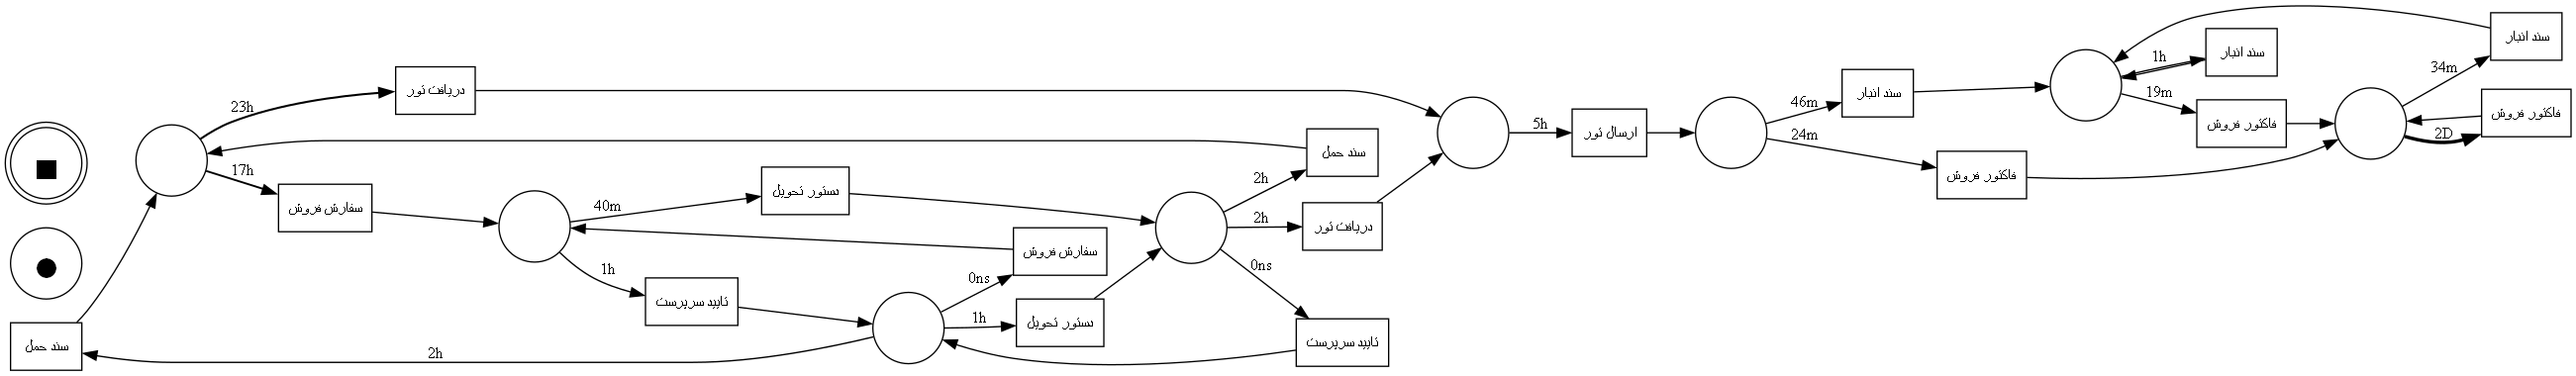

In [86]:
# Miner
dfg = dfg_discovery.apply(log, variant = dfg_discovery.Variants.PERFORMANCE)

# Convert
net, initial_marking, final_marking = dfg_converter.apply(dfg)

# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           variant = pn_visualizer.Variants.PERFORMANCE, 
                           log = log)

# Save
pn_visualizer.save(gviz, IMAGE_DIR / 'ProcessDiscovery/dfg_performance_petri.png')

# View
pn_visualizer.view(gviz)

<br></br>
#### <b>3.3.2.2. Frequency<b>

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

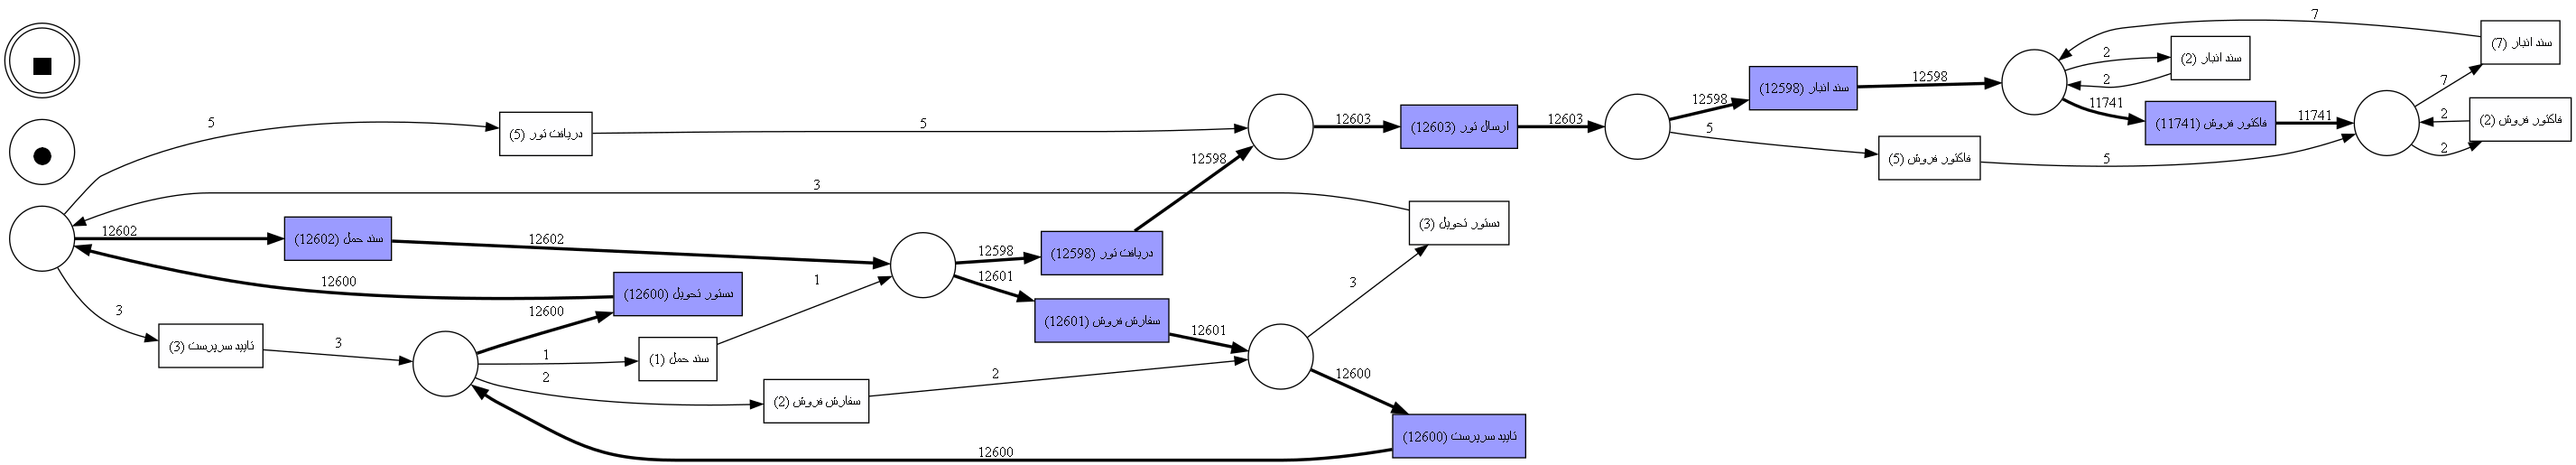

In [87]:
# Miner
dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.FREQUENCY)

# Convert
net, initial_marking, final_marking = dfg_converter.apply(dfg)

# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking,
                           variant = pn_visualizer.Variants.FREQUENCY, 
                           log = log)

# Save
pn_visualizer.save(gviz, IMAGE_DIR / 'ProcessDiscovery/dfg_frequency_petri.png')

# View
pn_visualizer.view(gviz)

<br></br>
## <b>3.4. Interactive Process Map</b>

In [88]:
def heuristics_process_model(dependency_threshold, and_threshold, loop_two_threshold):
    # Parameters
    parameters = heuristics_miner.Variants.CLASSIC.value.Parameters

    # Miner
    petri_net, initial_marking, final_marking = heuristics_miner.apply(
        log,
        variant=heuristics_miner.Variants.CLASSIC, 
        parameters={
            parameters.DEPENDENCY_THRESH: dependency_threshold, 
            parameters.AND_MEASURE_THRESH: and_threshold,
            parameters.LOOP_LENGTH_TWO_THRESH: loop_two_threshold
        }
    )

    # GraphViz
    gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking,
                               variant=pn_visualizer.Variants.FREQUENCY, 
                               log=log)
    
    # Save
    pn_visualizer.save(gviz, IMAGE_DIR / 'ProcessDiscovery/heuristic_miner_4.png')
    
    # View
    vis_utils.view_image_in_jupyter(IMAGE_DIR / 'ProcessDiscovery/heuristic_miner_4.png')



interact(
    heuristics_process_model,

    dependency_threshold = widgets.FloatSlider(
        value=0.5, min=0, max=1, step=0.01, description='Dependency:', 
        disabled=False, continuous_update=False, orientation='horizontal', 
        readout=True, readout_format='.2f'
    ),

    and_threshold = widgets.FloatSlider(
        value=0.65, min=0, max=1, step=0.01, description='And:', 
        disabled=False, continuous_update=False, orientation='horizontal', 
        readout=True, readout_format='.2f'
    ),

    loop_two_threshold = widgets.FloatSlider(
        value=0.5, min=0, max=1, step=0.01, description='Loop Two:', 
        disabled=False, continuous_update=False, orientation='horizontal', 
        readout=True, readout_format='.2f'
    ),
)

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='Dependency:', max=1.0, step…

<function __main__.heuristics_process_model(dependency_threshold, and_threshold, loop_two_threshold)>

<br></br>
## <b>3.5. Correlation Miner</b>

In [89]:
df = log[["concept:name", "time:timestamp"]]

frequency_dfg, performance_dfg = correlation_miner.apply(df, parameters={"pm4py:param:activity_key": "concept:name",
                                                                         "pm4py:param:timestamp_key": "time:timestamp"})


In [90]:
activities_freq = dict(df["concept:name"].value_counts())
activities_freq

{'سند انبار': 12607,
 'سفارش فروش': 12603,
 'تاييد سرپرست': 12603,
 'دستور تحويل': 12603,
 'سند حمل': 12603,
 'دريافت تور': 12603,
 'ارسال تور': 12603,
 'فاکتور فروش': 11748}

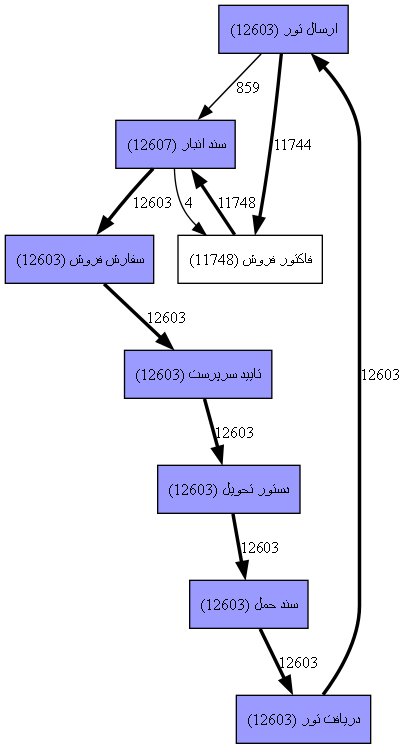

In [91]:
gviz_freq = dfg_visualizer.apply(frequency_dfg, variant=dfg_visualizer.Variants.FREQUENCY, activities_count=activities_freq)
dfg_visualizer.view(gviz_freq)

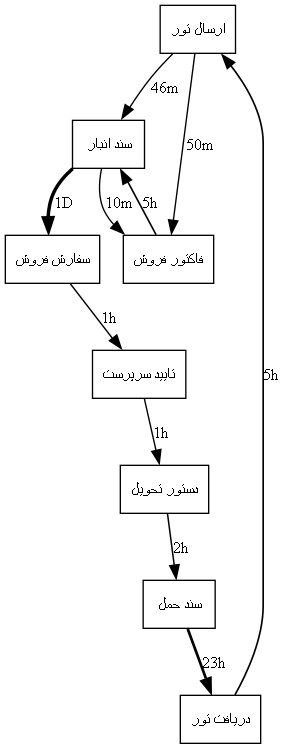

In [92]:
gviz_perf = dfg_visualizer.apply(performance_dfg, variant=dfg_visualizer.Variants.PERFORMANCE, activities_count=activities_freq)
dfg_visualizer.view(gviz_perf)

### <b>Tamrin 5:<b>

In [93]:
ad_df = activity_duration(log, 'Case_ID', 'Activity', 'Start_Timestamp').loc[:, ['event_from', 'event_to', 'duration (h)']]

ad_df = ad_df.groupby(by = ['event_from', 'event_to']).agg(
    mean_duration = ('duration (h)', 'mean'),
    total_duration = ('duration (h)', 'sum'),
    count = ('event_from', 'count')
).reset_index()

# ad_df.sort_values('total_duration', ascending=False)
ad_df

,event_from,event_to,mean_duration,total_duration,count
0,ارسال تور,سند انبار,0.776221,9778.830556,12598
1,ارسال تور,فاکتور فروش,0.413167,2.065833,5
2,تاييد سرپرست,دستور تحويل,1.171512,14761.049444,12600
3,تاييد سرپرست,سفارش فروش,0.000000,0.000000,2
4,تاييد سرپرست,سند حمل,2.216944,2.216944,1
5,دريافت تور,ارسال تور,5.796661,73055.320278,12603
6,دستور تحويل,تاييد سرپرست,0.000000,0.000000,1
7,دستور تحويل,دريافت تور,2.010444,10.052222,5
8,دستور تحويل,سند حمل,2.752190,34669.337222,12597
9,سفارش فروش,تاييد سرپرست,1.526036,19228.057778,12600


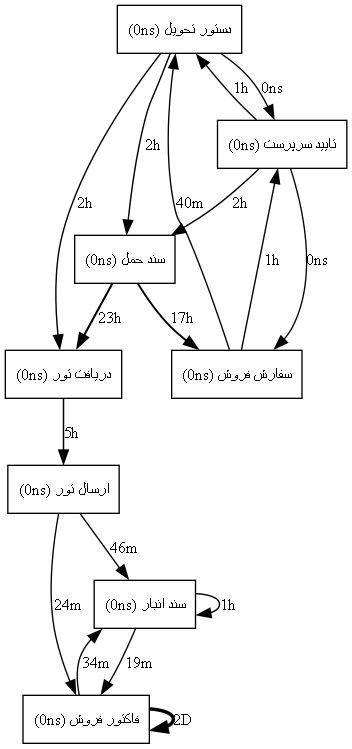

In [94]:
# Miner
dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.PERFORMANCE)

# GraphViz
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.PERFORMANCE)

# Save
dfg_visualization.save(gviz, IMAGE_DIR / 'ProcessDiscovery/dfg_performance.png')

# View
dfg_visualization.view(gviz)

In [95]:
sum_total =ad_df.total_duration.sum()

In [96]:
ad_df['total_fraction'] = round(ad_df.total_duration / sum_total * 100 , 2)

In [97]:
ad_df.sort_values(by = ['total_fraction'], ascending=False)

,event_from,event_to,mean_duration,total_duration,count,total_fraction
13,سند حمل,دريافت تور,23.510841,296189.579167,12598,65.57
5,دريافت تور,ارسال تور,5.796661,73055.320278,12603,16.17
8,دستور تحويل,سند حمل,2.752190,34669.337222,12597,7.68
9,سفارش فروش,تاييد سرپرست,1.526036,19228.057778,12600,4.26
2,تاييد سرپرست,دستور تحويل,1.171512,14761.049444,12600,3.27
0,ارسال تور,سند انبار,0.776221,9778.830556,12598,2.16
12,سند انبار,فاکتور فروش,0.319658,3753.103889,11741,0.83
16,فاکتور فروش,فاکتور فروش,69.755417,139.510833,2,0.03
14,سند حمل,سفارش فروش,17.974056,89.870278,5,0.02
6,دستور تحويل,تاييد سرپرست,0.000000,0.000000,1,0.00


In [98]:
#پس از بررسی دی اف جی گراف و تحلیل کارایی بین هر یک از فعالیت ها، مشخص گردید نسبت زمانی بین دو فعالیت "سند حمل" و "دریافت تور" بسیار زمانبر است. حدود 65 درصد از کل زمان فالیت ها 
#بنابراین، می بایست فکر چاره ای درکاهش زمان بین این دو فعالیت انجام داد 


### <b>Tamrin 7:<b>

In [150]:
df_org = dataset[['Case_ID', 'Cust_ID', 'Area_ID', 'Cust_code', 'Marketer_ID', 'Ret_status', 'Dist_ID', 'Payment_type']].groupby(by=['Case_ID']).apply(lambda x: x.mode().iloc[0]).reset_index(drop=True)
df_org.drop('Case_ID', axis=1, inplace=True)

In [100]:
from sklearn.preprocessing import LabelEncoder

In [101]:
#https://medium.com/aiskunks/categorical-data-encoding-techniques-d6296697a40f

class encode_feature:
    def __init__(self, data, cols, drop=False, inplace=False, target='' , target2=pd.DataFrame()):
    #def __init__(self, data, cols, drop=False, inplace=False, target='' , target2=pd.DataFrame()):
        self.data = data
#         self.data2 = self.data.copy()
#         self.data2.drop('Survived',inplace=True, axis=1)
        self.cols = cols
        self.drop = drop
        self.inplace = inplace
        self.target = target
        self.target2 = target2
        self.encoded_data = pd.DataFrame()
        for col in self.cols:
            if self.data[col].dtype != 'object' and  self.data[col].dtype != 'category':
                cols.remove(col)                
                print (f"The feature {col} is not categorical!")

    def one_hot (self):
        for col in self.cols:
            one_hot = pd.get_dummies(self.data[col], prefix=col)
            self.data = pd.concat([self.data, one_hot], axis=1)
            self.encoded_data = pd.concat([self.encoded_data, self.data[col], one_hot], axis=1)       
        return self.return_value()

    
    def dummy (self):
        for col in self.cols:
            dummy_df = pd.get_dummies(self.data[col], drop_first=True, prefix=col)
            self.data = pd.concat([self.data, dummy_df], axis=1)
            self.encoded_data = pd.concat([self.encoded_data, self.data[col], dummy_df], axis=1)       
        return self.return_value()

    
    def label (self):
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        for col in self.cols:
            self.data[f'{col}_encoded'] = le.fit_transform(self.data[col])    
            #self.data = pd.concat([self.data, self.data[f'{col}_encoded']], axis=1)
            self.encoded_data = pd.concat([self.encoded_data, self.data[col], self.data[f'{col}_encoded']], axis=1)       
        return self.return_value()

    def ordinal (self):
        for col in self.cols:
            quality_dict = {value: index for index, value in enumerate(self.data[col].unique())}
            self.data[f'{col}_encoded'] = self.data[col].map(quality_dict)
            self.encoded_data = pd.concat([self.encoded_data, self.data[col], self.data[f'{col}_encoded']], axis=1)       
        return self.return_value()

    def binary (self):
        for col in self.cols:
            quality_dict = {value: index for index, value in enumerate(self.data[col].unique())}
            self.data[f'{col}_encoded'] = self.data[col].map(quality_dict).apply(lambda x: format(x, 'b'))
            self.encoded_data = pd.concat([self.encoded_data, self.data[col], self.data[f'{col}_encoded']], axis=1)       
        return self.return_value()

    def count (self):
        for col in self.cols:
            counts = self.data[col].value_counts()
            self.data[f'{col}_encoded'] = self.data[col].map(counts)
            self.encoded_data = pd.concat([self.encoded_data, self.data[col], self.data[f'{col}_encoded']], axis=1)       
        return self.return_value()

    def target_encoder (self):
        for col in self.cols:
            #self.data = pd.concat([self.data, df[self.target]], axis=1)
            target_mean = self.data.groupby(col)[self.target].mean()
            self.data[f'{col}_encoded'] = self.data[col].map(target_mean)
            self.encoded_data = pd.concat([self.encoded_data, self.data[col], self.data[f'{col}_encoded']], axis=1)       
        return self.return_value()


#     def target_encoder2 (self):
#         for col in self.cols:
#             self.data2 = pd.concat([self.data2, self.target2], axis=1)
#             print(self.data2.columns[-1])
#             target_mean = self.data2.groupby(col)[self.data2.columns[-1]].mean()
#             print(target_mean)
#             self.data2[f'{col}_encoded'] = self.data2[col].map(target_mean)
#             self.encoded_data = pd.concat([self.encoded_data, self.data2[col], self.data2[f'{col}_encoded']], axis=1)       
#         return self.return_value()
    
    def return_value (self):
        if self.drop:
            self.data = self.data.drop(self.cols, axis=1)
            self.encoded_data = self.encoded_data.drop(self.cols, axis=1)
        if self.inplace:
            return self.data
        else:
            return self.encoded_data


In [102]:
# MinMaxScaler
def minmax_scaler (data):
    
    if not([col for col in data.columns if data[col].dtype == 'object']):
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        return pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    else:
        print ("No action was committed! There is at least one feature which has categorical values!")
        return data

In [134]:
#https://elitedatascience.com/imbalanced-classes
#https://imbalanced-learn.org/stable/over_sampling.html
# ----------------------------------------------------------------

#https://www.youtube.com/watch?v=4SivdTLIwHc
#https://github.com/dataprofessor/imbalanced-data

#! pip install -U imbalanced-learn

def show_balancing(data, target):
    data[target].value_counts().plot.pie(autopct='%.2f')
    #fig1, ax1 = plt.subplots()
    #ax1.pie(data[target].value_counts(), autopct='%.2f', labels=data[target].value_counts().index)


def under_sampling (data, target):
    from imblearn.under_sampling import RandomUnderSampler
    
    y = data[[target]]
    X = data.drop(target, axis=1)
    
    rus = RandomUnderSampler(sampling_strategy=1) # Numerical value
    # rus = RandomUnderSampler(sampling_strategy="not minority") # String
    X_res, y_res = rus.fit_resample(X, y)

    ax = y_res.value_counts().plot.pie(autopct='%.2f')
    _ = ax.set_title("Under-sampling")
    
    return pd.concat([X_res, y_res], axis = 1)

def over_sampling (data, target):
    from imblearn.over_sampling import RandomOverSampler
    
    y = data[[target]]
    X = data.drop(target, axis=1)
    
    ros = RandomOverSampler(sampling_strategy=1) # Numerical value
    # rus = RandomOverSampler(sampling_strategy="not minority") # String
    X_res, y_res = ros.fit_resample(X, y)

    ax = y_res.value_counts().plot.pie(autopct='%.2f')
    _ = ax.set_title("Over-sampling")
    
    return pd.concat([X_res, y_res], axis = 1)


In [151]:
df_org.head()

,Cust_ID,Area_ID,Cust_code,Marketer_ID,Ret_status,Dist_ID,Payment_type
0,14021788,202012,1,E5700979,مرجوع نشده,E5700198,PTCA
1,14023383,202012,1,E5700979,مرجوع نشده,E5700198,PTCA
2,14024191,202015,1,E5700244,مرجوع نشده,E5700211,PTCA
3,14025292,202005,1,E5700242,مرجوع نشده,E5701241,PTCA
4,14028229,202005,1,E5700918,مرجوع نشده,E5700917,PTCA


In [152]:
[len(df_org[x].unique()) for x in df_org.columns]


[4678, 21, 6, 16, 2, 11, 4]

In [153]:
pd.set_option('display.max_columns', None)
df_encoded = df_org.copy()
encodd = encode_feature(df_encoded, ['Area_ID','Marketer_ID','Ret_status', 'Dist_ID', 'Payment_type'], True, True, 'Ret_status')
df_encoded = encodd.one_hot()
df_encoded.head()

The feature Area_ID is not categorical!


,Cust_ID,Area_ID,Cust_code,Marketer_ID_E2327471,Marketer_ID_E5700195,Marketer_ID_E5700197,Marketer_ID_E5700206,Marketer_ID_E5700216,Marketer_ID_E5700218,Marketer_ID_E5700233,Marketer_ID_E5700237,Marketer_ID_E5700242,Marketer_ID_E5700244,Marketer_ID_E5700245,Marketer_ID_E5700918,Marketer_ID_E5700979,Marketer_ID_E5701224,Marketer_ID_E5701225,Marketer_ID_E5701645,Ret_status_مرجوع شده,Ret_status_مرجوع نشده,Dist_ID_E5700198,Dist_ID_E5700204,Dist_ID_E5700211,Dist_ID_E5700228,Dist_ID_E5700238,Dist_ID_E5700896,Dist_ID_E5700917,Dist_ID_E5701241,Dist_ID_E5701472,Dist_ID_E5701526,Dist_ID_E5701554,Payment_type_PT01,Payment_type_PT02,Payment_type_PTCA,Payment_type_PTCH
0,14021788,202012,1,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,14023383,202012,1,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,14024191,202015,1,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
3,14025292,202005,1,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False
4,14028229,202005,1,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False


In [154]:
df_encoded = minmax_scaler (df_encoded[df_encoded.columns])
df_encoded.head()

,Cust_ID,Area_ID,Cust_code,Marketer_ID_E2327471,Marketer_ID_E5700195,Marketer_ID_E5700197,Marketer_ID_E5700206,Marketer_ID_E5700216,Marketer_ID_E5700218,Marketer_ID_E5700233,Marketer_ID_E5700237,Marketer_ID_E5700242,Marketer_ID_E5700244,Marketer_ID_E5700245,Marketer_ID_E5700918,Marketer_ID_E5700979,Marketer_ID_E5701224,Marketer_ID_E5701225,Marketer_ID_E5701645,Ret_status_مرجوع شده,Ret_status_مرجوع نشده,Dist_ID_E5700198,Dist_ID_E5700204,Dist_ID_E5700211,Dist_ID_E5700228,Dist_ID_E5700238,Dist_ID_E5700896,Dist_ID_E5700917,Dist_ID_E5701241,Dist_ID_E5701472,Dist_ID_E5701526,Dist_ID_E5701554,Payment_type_PT01,Payment_type_PT02,Payment_type_PTCA,Payment_type_PTCH
0,0.803559,0.992958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.803879,0.992958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.804041,0.994467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.804261,0.989437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.804849,0.989437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [155]:
#! pip install -U imbalanced-learn

,Cust_ID,Area_ID,Cust_code,Marketer_ID_E2327471,Marketer_ID_E5700195,Marketer_ID_E5700197,Marketer_ID_E5700206,Marketer_ID_E5700216,Marketer_ID_E5700218,Marketer_ID_E5700233,Marketer_ID_E5700237,Marketer_ID_E5700242,Marketer_ID_E5700244,Marketer_ID_E5700245,Marketer_ID_E5700918,Marketer_ID_E5700979,Marketer_ID_E5701224,Marketer_ID_E5701225,Marketer_ID_E5701645,Ret_status_مرجوع نشده,Dist_ID_E5700198,Dist_ID_E5700204,Dist_ID_E5700211,Dist_ID_E5700228,Dist_ID_E5700238,Dist_ID_E5700896,Dist_ID_E5700917,Dist_ID_E5701241,Dist_ID_E5701472,Dist_ID_E5701526,Dist_ID_E5701554,Payment_type_PT01,Payment_type_PT02,Payment_type_PTCA,Payment_type_PTCH,Ret_status_مرجوع شده
0,0.803559,0.992958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.803879,0.992958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.804041,0.994467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.804261,0.989437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.804849,0.989437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


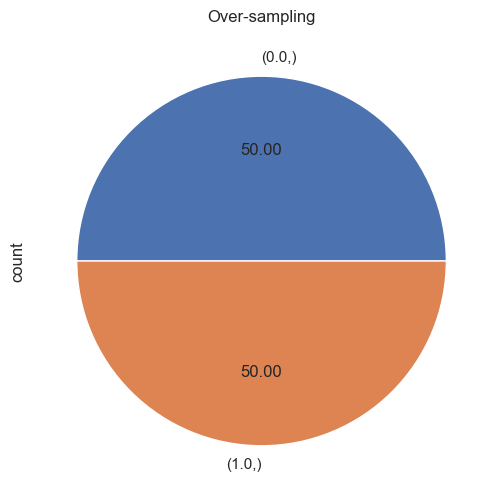

In [156]:
df2 = over_sampling(df_encoded, 'Ret_status_مرجوع شده')
df2.head()
#df2['Ret_status_مرجوع شده']()


In [143]:
from sklearn.model_selection import train_test_split

In [157]:
#Total X (independed features)
X = df2.drop(['Ret_status_مرجوع شده','Ret_status_مرجوع نشده'] , axis=1)
#Total Y (Target feature)
Y = df2[['Ret_status_مرجوع نشده']]
#generating Xtrain, Xtest (independed features for train set and test set) 
#and Ytrain, Ytest (Targer feature for train set and test set)
Xtrain, Xtest, Ytrain, Ytest = train_test_split (X, Y, test_size=0.2, random_state=2020)

In [158]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
#Creting instance
DTP = DecisionTreeClassifier(
    criterion = 'gini',
    max_depth=3,
    min_samples_split=4,
    min_samples_leaf=5,
    #random_state=42
)
#Learning from train set
DTP.fit(Xtrain, Ytrain)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, min_samples_split=4)

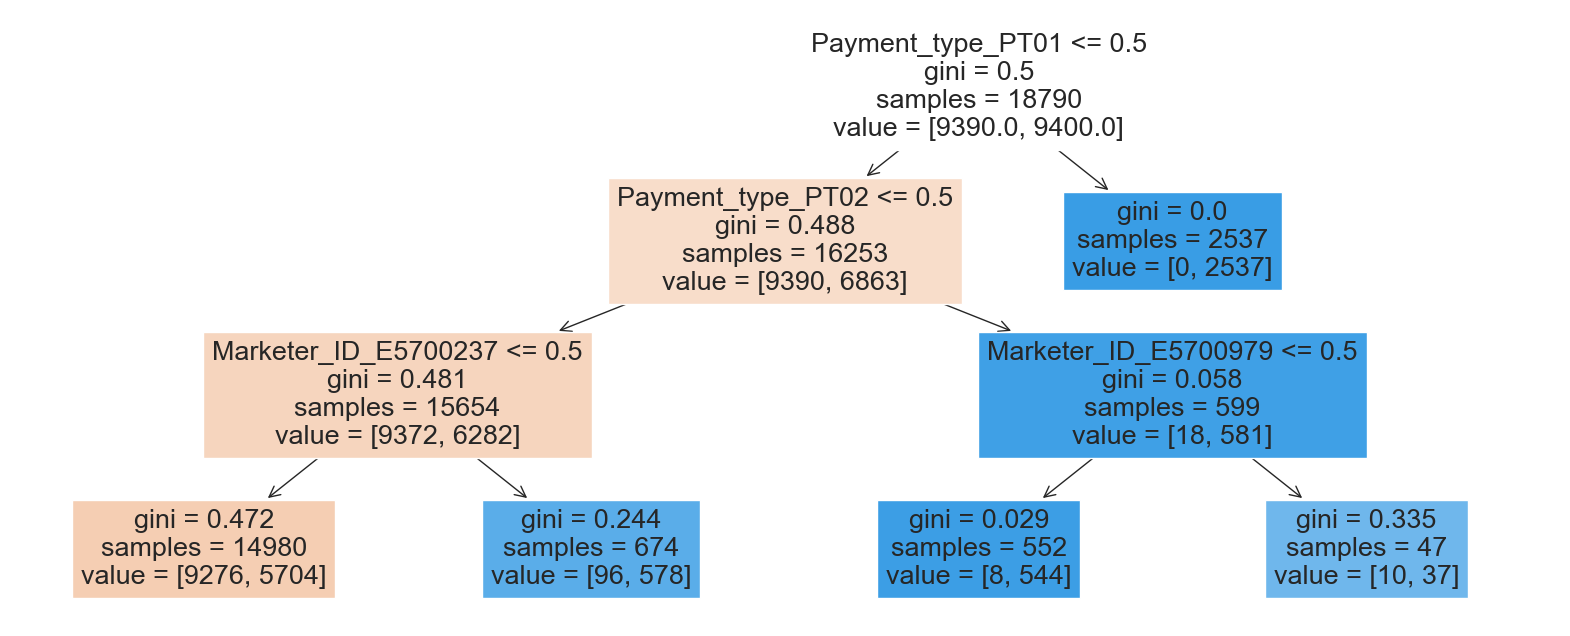

In [146]:
from sklearn.tree import plot_tree
plt.figure(figsize = (20,8))
plot_tree(DTP,feature_names=X.columns, filled = True);

In [160]:
#Predict the goal for test set and calculate accuracy

from sklearn.metrics import accuracy_score
accuracy_score(Ytest,DTP.predict(Xtest))

0.7017879948914432

In [159]:
#Calculating Confusion Matrix 
from sklearn.metrics import confusion_matrix
confusion_matrix(Ytrain,DTP.predict(Xtrain))

array([[8968,  422],
       [5255, 4145]], dtype=int64)

In [161]:
#Calculating Confusion Matrix 
from sklearn.metrics import confusion_matrix
confusion_matrix(Ytest,DTP.predict(Xtest))

array([[2249,  105],
       [1296, 1048]], dtype=int64)

In [162]:
#Random Forest 
from sklearn.ensemble import RandomForestClassifier

DTP = RandomForestClassifier(max_depth=4, random_state=42)
DTP.fit(Xtrain, Ytrain)
score_5 = accuracy_score(Ytest,DTP.predict(Xtest))
score_5

0.707960834397616